In [1]:
import numpy as np 
import pandas as pd
from hmmlearn import hmm
from matplotlib import pyplot as plt
import seaborn as sbn
from matplotlib.patches import Ellipse
import umap
import pickle as pkl
import networkx as nx
import tsfel
from sklearn import decomposition

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Overview 


This is a template analysis notebook, it is suggested that you make a copy of this file and then change the data and methods as desired. 

We will implement three analysis: 

1. Hidden Markov Model 

2. Time Series Feature Extraction 

3. Pathway correllation analysis 


TODO: (**HIGH**) Descroptions and slide deck for presentation with samuel.   
TODO: Use different dataset/experiment for comparison 


# Load Data 

The data should be in `pickle` form. For more info, see the relevant `data_org.ipynb` notebooks. 

In [2]:
with open('../data/H190923.pkl', 'rb') as f: 
    data = pkl.load(f)
data.head()

track_index  erk_time(h)=0.0  erk_time(h)=0.2  \
0  78_1000101697_k562_erk_akt__untreated         0.666206         0.583154   
1  77_1000098381_k562_erk_akt__untreated         0.646522         0.419623   
2   4_1000007026_k562_erk_akt__untreated         0.731499         0.644271   
3   2_1000002957_k562_erk_akt__untreated         0.860727         0.690160   
4  82_1000111191_k562_erk_akt__untreated         0.547424         0.521789   

   erk_time(h)=0.5  erk_time(h)=0.8  erk_time(h)=1.0  erk_time(h)=1.2  \
0         0.464076         0.401721         0.574265         0.628919   
1         0.636420         0.608784         0.593370         0.594475   
2         0.565533         0.405811         0.538459         0.716891   
3         0.633814         0.886553         0.915976         0.856283   
4         0.448863         0.573173         0.504300         0.525133   

   erk_time(h)=1.5  erk_time(h)=1.8  erk_time(h)=2.0  ...  akt_time(h)=13.5  \
0         0.533323         0.639510         0.808772  ...          0.498220   
1         0.764531         0.781966         0.703256  ...          0.630918   
2         0.771548         0.708265         0.789968  ...          0.835404   
3         0.759563         0.927312         0.948254  ...          0.749850   
4         0.493384         0.638652         0.621023  ...          0.684539   

   akt_time(h)=13.8  akt_site  akt_median  conc_nm  inhibitor  cell_line  \
0          0.523217        78    0.496346      0.0       none       k562   
1          0.623906        77    0.503596      0.0       none       k562   
2          0.626950         4    0.642910      0.0       none       k562   
3          0.384942         2    0.541348      0.0       none       k562   
4          0.720796        82    0.609912      0.0       none       k562   

   control_OD  optical_density  cell_viab  
0         NaN              NaN        1.0  
1         NaN              NaN        1.0  
2         NaN              NaN        1.0  
3         NaN              NaN        1.0  
4         NaN              NaN        1.0  

[5 rows x 124 columns]

# Config. Parameters 

In [131]:
# HMM params 
nstates = 20
niter   = 50

# Data Visualization 

Detecting cycles in time series 
https://github.com/oemof/cydets

There should be a cell division cycle we can see in this... right? 

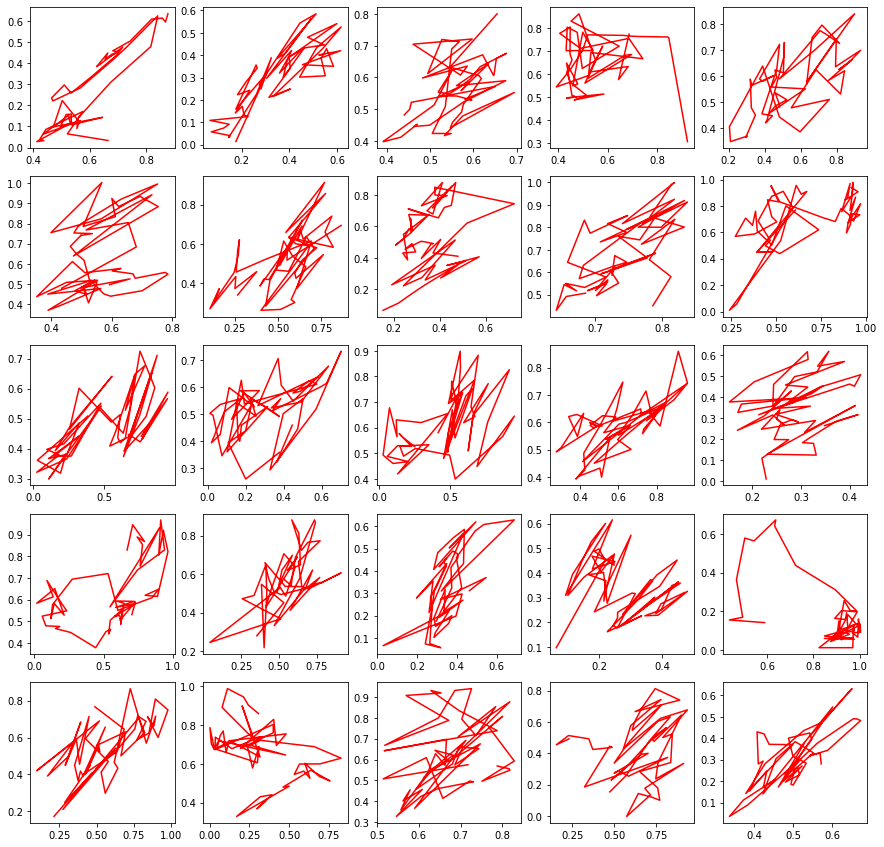

In [85]:
f, axes = plt.subplots(5,5, figsize=(15,15))
for i,row in data.sample(25).reset_index().iterrows(): 
    __x = row[data.attrs['clover_selector']]
    __y = row[data.attrs['mscarlet_selector']]
    axes.flat[i].plot(__x, __y, 'r-', alpha=1)

# Analysis 1: Hidden Markov Model (HMM)

HMM using [this](https://hmmlearn.readthedocs.io/en/latest/) package. 

The base HMM will be trained from unperturbed treatment group. 

Alternatively, [this](https://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html) is another option <- significantly faster training, parrellization and more flexible. 

In [86]:
def form_data(df): 
    # https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
    X = np.concatenate((df[df.attrs['clover_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1), 
                        df[df.attrs['mscarlet_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1)), 
                       axis=2)
    
    _lens = [X.shape[1]]*X.shape[0]
    X = X.reshape((-1, 2))
    
    print('shape:', X.shape)
    return X, _lens

In [87]:
data.cell__treatment.unique()

array(['k562_erk_akt__untreated', 'k562_erk_akt__0.625nm_dasatinib',
       'k562_erk_akt__1.25nm_dasatinib', 'k562_erk_akt__2.5nm_dasatinib',
       'k562_erk_akt__5nm_dasatinib', 'k562_erk_akt__10nm_dasatinib',
       'k562_erk_akt__100nm_dasatinib', 'k562_erk_akt__1000nm_dasatinib',
       'k562_erk_akt__10um trametinib', 'k562_erk_akt__10um_mk2206'],
      dtype=object)

In [128]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
untreated = data[data.cell__treatment=='k562_erk_akt__untreated']
X_untreated, untreated_lens = form_data(untreated)

shape: (4480, 2)


In [129]:
X, _lens = form_data(data)

shape: (45696, 2)


In [90]:
def get_HMM(X, lengths, nstates, niter, means=None, verbose=True): 
    
    if means is not None: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='stc')
        remodel.means_ = means
    else: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='mstc')

    # train 
    remodel.fit(X, lengths)
    if verbose: print('model converged:', remodel.monitor_.converged)

    return remodel 

# Check HMM convergence 

In [91]:
def plot_convergence_variance(X, lens, nruns=25, nstates=10, niter=5):

    _hmms_ = {'iter':[], 'clover':[], 'mscarlet':[]}
    for i in range(nruns):
        print('iter:', i, end='\r')
        _hmms_['iter'].append(i)
        h = get_HMM(X.copy(), lens.copy(), nstates=nstates, niter=niter, verbose=False)
        _hmms_['clover'].append( h.means_[:,0] ) 
        _hmms_['mscarlet'].append( h.means_[:,1] ) 
    _hmms_ = pd.DataFrame(_hmms_)

    plt.figure()
    for i,row in _hmms_.iterrows(): 
        plt.plot(row.clover, row.mscarlet, 'b.')
    plt.title(f'nruns={nruns} | nstates={nstates} | niter={niter}')
    plt.show()

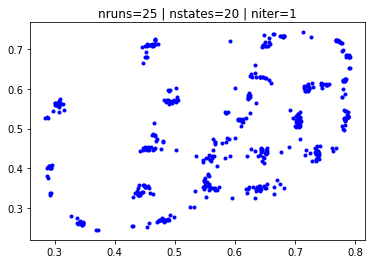

In [122]:
plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=1)

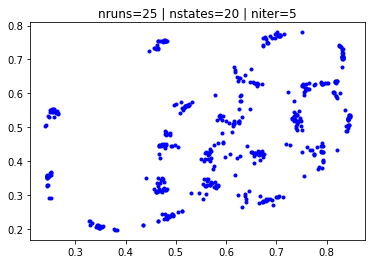

In [123]:
plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=5)

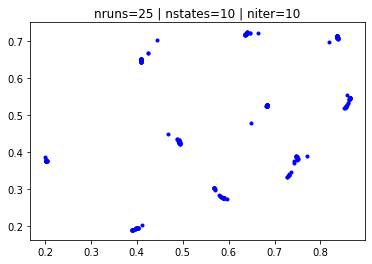

In [124]:
plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=10)

# Train HMM

In [132]:
# init model
remodel = get_HMM(X_untreated, untreated_lens, nstates, niter)
#remodel = get_HMM(X, _lens, nstates, niter)

# get states 
Z2 = remodel.predict(X, _lens) # switch this to  X_untreated... ? 

model converged: True


In [133]:
# reshape to original observations 
z2 = Z2.reshape((-1, len(data.attrs['clover_selector'])))
z2.shape

(816, 56)

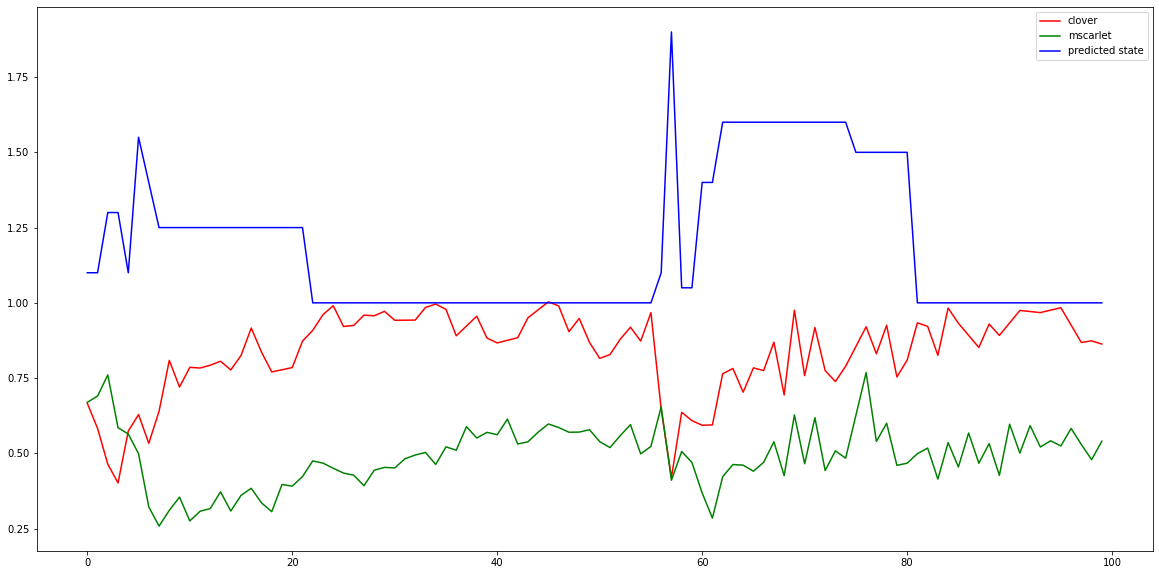

In [134]:
plt.figure(figsize=(20,10))
_n = 100
plt.plot(X[:_n, 0], 'r', label='clover')
plt.plot(X[:_n, 1], 'g', label='mscarlet')
plt.plot(Z2[:_n]/nstates + 1, 'b', label='predicted state')
plt.legend()

plt.show()

In [135]:
# create wide dataframe with track labesl 
res = pd.DataFrame(z2, columns=[float(x.split('=')[-1]) for x in data.attrs['clover_selector']])
res = res.assign(label=data.track_index)

# unstack time - long data
res = res.set_index('label').unstack().reset_index().rename({'level_0':'time', 0:'state'}, axis=1)
res.head()

time                                  label  state
0   0.0  78_1000101697_k562_erk_akt__untreated      2
1   0.0  77_1000098381_k562_erk_akt__untreated      2
2   0.0   4_1000007026_k562_erk_akt__untreated      2
3   0.0   2_1000002957_k562_erk_akt__untreated     11
4   0.0  82_1000111191_k562_erk_akt__untreated      6

In [136]:
# count the # time points spent in each sate - for each time series (cell)
out = res.groupby(['label','state']).count().rename({'time':'count'},axis=1).reset_index().set_index('label').pivot(columns='state', values='count').reset_index()

# if a cell never occupies a state, then it is listed as na  -replace these as 0
out = out.fillna(0)

# assign treatments 
out = out.assign(cell__treatment= [x.split('_', 2)[-1] for x in out.label])

# rename states for convenience 
out = out.rename({x:f'state_{x}' for x in out.columns[1:-1]}, axis=1)

# init state_selector to grab relevant col later 
state_sel = out.columns[1:-1]

# merge cell_viab 
out = out.merge(data[['track_index', 'cell_viab']], left_on='label', right_on='track_index', how='left')
out.head()

label  state_0  state_1  state_2  \
0  100_1000161896_k562_erk_akt__5nm_dasatinib      0.0      0.0      8.0   
1  100_1000162187_k562_erk_akt__5nm_dasatinib      0.0      0.0      0.0   
2  100_1000162922_k562_erk_akt__5nm_dasatinib      0.0      0.0      0.0   
3  100_1000163162_k562_erk_akt__5nm_dasatinib      0.0      0.0      8.0   
4  100_1000163479_k562_erk_akt__5nm_dasatinib      0.0      0.0     27.0   

   state_3  state_4  state_5  state_6  state_7  state_8  ...  state_13  \
0      0.0      0.0      0.0      4.0      7.0      0.0  ...      16.0   
1      0.0     52.0      0.0      0.0      0.0      4.0  ...       0.0   
2      0.0      0.0      0.0     27.0      0.0      0.0  ...       0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0   
4      0.0      0.0      0.0     13.0      0.0      0.0  ...      12.0   

   state_14  state_15  state_16  state_17  state_18  state_19  \
0       0.0       0.0       0.0      10.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0   
2      28.0       0.0       0.0       0.0       0.0       1.0   
3       6.0       0.0       0.0       0.0      13.0       0.0   
4       4.0       0.0       0.0       0.0       0.0       0.0   

               cell__treatment                                 track_index  \
0  k562_erk_akt__5nm_dasatinib  100_1000161896_k562_erk_akt__5nm_dasatinib   
1  k562_erk_akt__5nm_dasatinib  100_1000162187_k562_erk_akt__5nm_dasatinib   
2  k562_erk_akt__5nm_dasatinib  100_1000162922_k562_erk_akt__5nm_dasatinib   
3  k562_erk_akt__5nm_dasatinib  100_1000163162_k562_erk_akt__5nm_dasatinib   
4  k562_erk_akt__5nm_dasatinib  100_1000163479_k562_erk_akt__5nm_dasatinib   

   cell_viab  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  

[5 rows x 24 columns]

In [137]:
# make sure the counts for each state sum to the # time points ... 
out[state_sel].sum(axis=1).unique()

array([56.])

In [138]:
# calc total number of time series observations in each treatment group 
tot = out.groupby(['cell__treatment'])['label'].count().reset_index()
tot = tot.assign(label=lambda x: x.label*len(data.attrs['clover_selector'])) # account number of time points 

# calc total amount of time spent in each state within each treatment group 
cnts = out.groupby('cell__treatment').sum().reset_index()

# normalize 
norm_cnts = pd.DataFrame((cnts[state_sel].values.T/tot.label.values).T, columns=state_sel).assign(cell__treatment=cnts.cell__treatment)

In [139]:
# double check we calculated our probabilites properly 
#norm_cnts[state_sel].sum(axis=1)

## pca on proprotion in each state - treatment group viz 

In [140]:
# TODO: add variation plot for PC's 

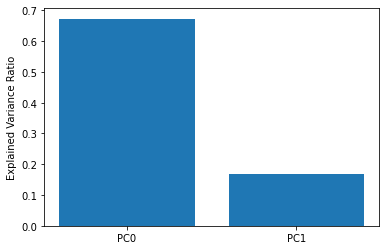

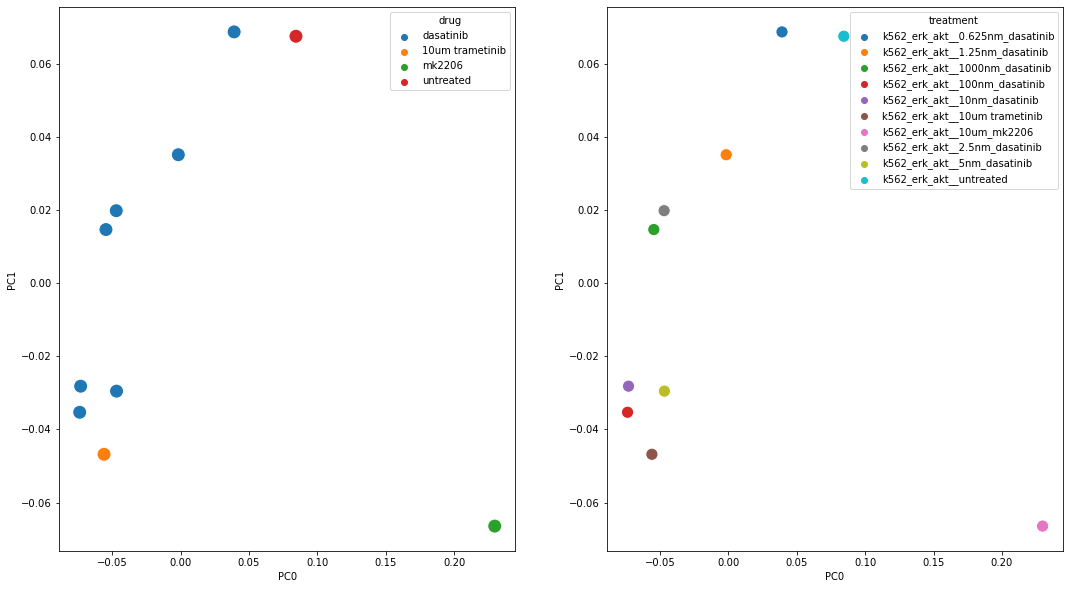

In [141]:
_X = norm_cnts[state_sel]

pca = decomposition.PCA(n_components=2)
pca.fit(_X)
_X2 = pca.transform(_X)

_df = pd.DataFrame(_X2, columns=['PC0', 'PC1']).assign(treatment=norm_cnts.cell__treatment)
_df = _df.assign(drug = [x.split('_')[-1] for x in norm_cnts.cell__treatment])

plt.figure()
plt.bar(height=pca.explained_variance_ratio_, x=['PC0', 'PC1'])
plt.ylabel('Explained Variance Ratio')
plt.show()

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=_df, ax=axes[0], s=200)
sbn.scatterplot(x='PC0', y='PC1', hue='treatment', data=_df, ax=axes[1], s=150)
plt.show()

# treatment group viz - all state prob

In [142]:
viz = norm_cnts.set_index('cell__treatment').unstack().reset_index().rename({0:'prob'}, axis=1)
viz.head()

state                  cell__treatment      prob
0  state_0  k562_erk_akt__0.625nm_dasatinib  0.013932
1  state_0   k562_erk_akt__1.25nm_dasatinib  0.013769
2  state_0   k562_erk_akt__1000nm_dasatinib  0.000981
3  state_0    k562_erk_akt__100nm_dasatinib  0.001387
4  state_0     k562_erk_akt__10nm_dasatinib  0.000000

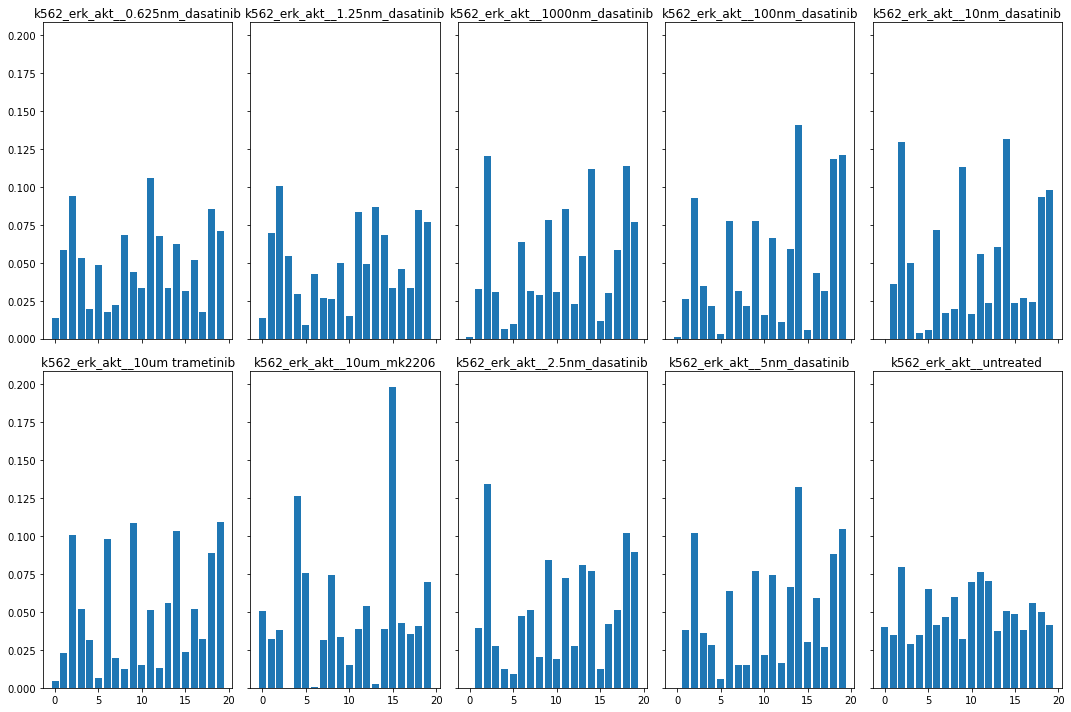

In [143]:
f, axes = plt.subplots(2,5, figsize=(15,10), sharex=True, sharey=True)
for i, row in norm_cnts.iterrows():
    x = row[state_sel].values
    axes.flat[i].bar(x=range(len(x)), height=x, label=row['cell__treatment'])
    axes.flat[i].set_title(row['cell__treatment'])
    
plt.tight_layout()
plt.show()

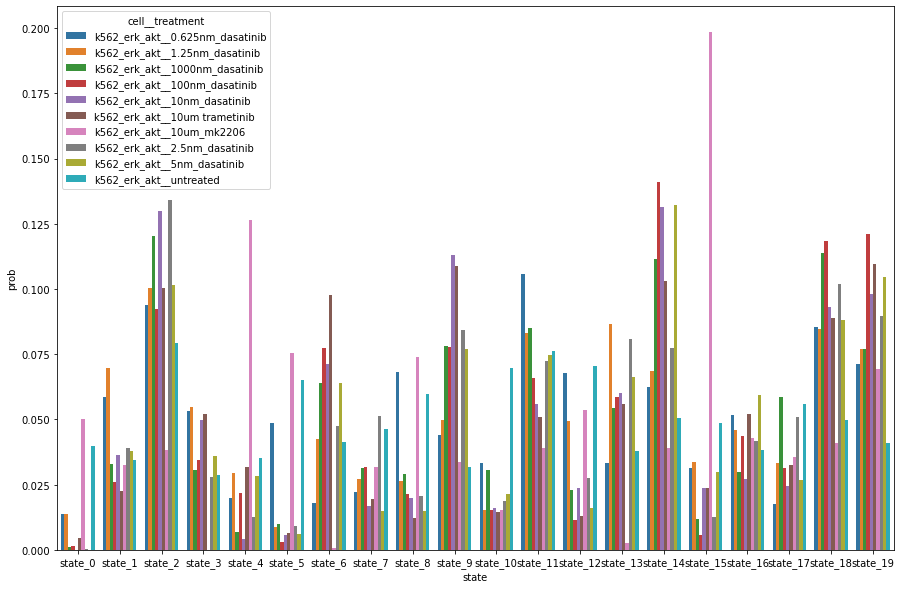

In [144]:
plt.figure(figsize=(15,10))
sbn.barplot(x='state', y='prob', hue='cell__treatment', data=viz)
plt.show()

# Which states are most common overall? 

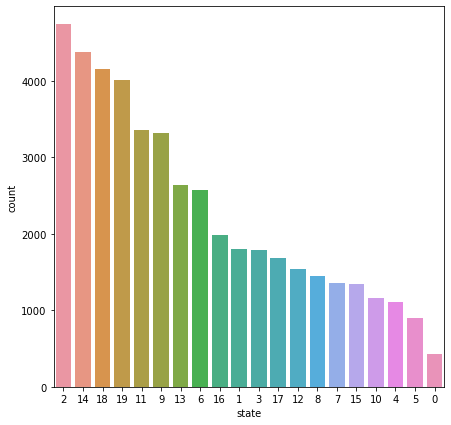

In [145]:
plt.figure(figsize=(7,7))
sbn.countplot(x='state', data=res, order=res.state.value_counts().index)
plt.show()

# Umap representation

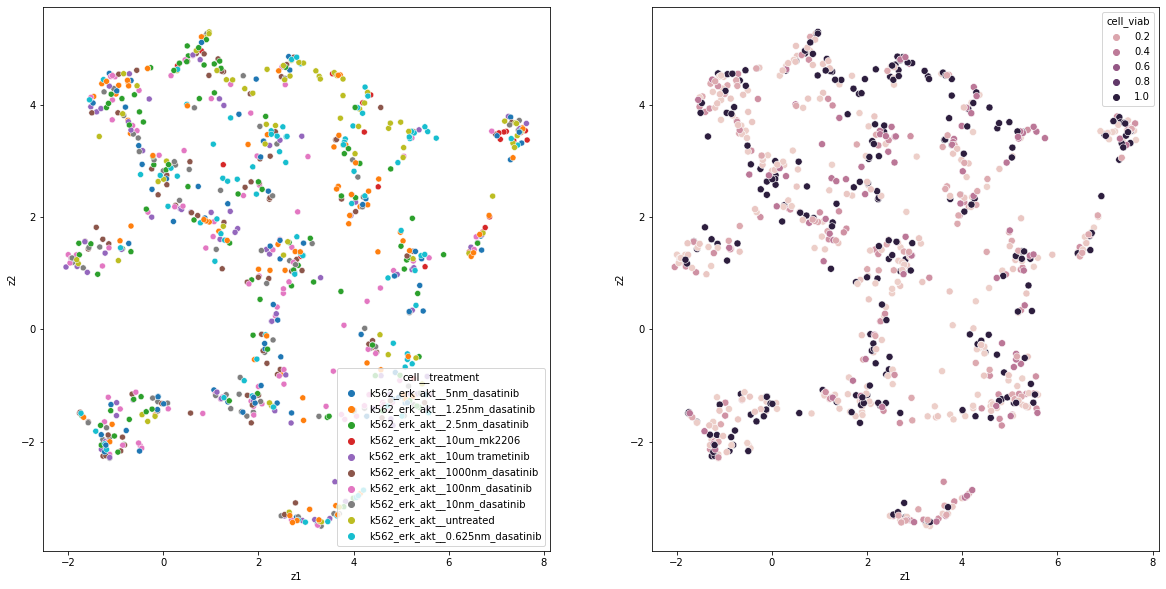

In [146]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='correlation')
embed = reducer.fit_transform(out[state_sel].values)

out = out.assign(z1=embed[:,0], z2=embed[:,1])

f,axes = plt.subplots(1,2,figsize=(20,10))
sbn.scatterplot(x='z1', y='z2', hue='cell__treatment', data=out, ax=axes[0])
sbn.scatterplot(x='z1', y='z2', hue='cell_viab', s=50, alpha=1, data=out, ax=axes[1])

plt.show()

<AxesSubplot:xlabel='z1', ylabel='z2'>

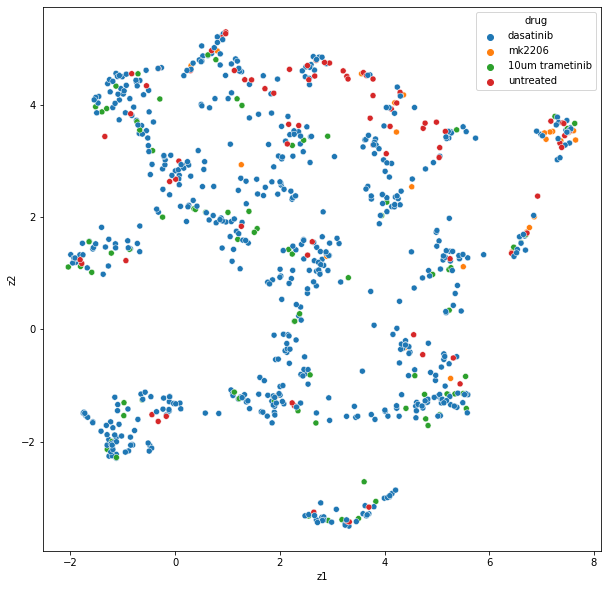

In [147]:
out2 = out.assign(drug = [x.split('_')[-1] for x in out.cell__treatment])
plt.figure(figsize=(10,10))
sbn.scatterplot(x='z1', y='z2', hue='drug', data=out2)

# Predict time-series  `treatment` from state probability 

We'll use this to understand the differences between treatment groups. e.g., what are the primary state differences between untreated and dasatinib? 

In [148]:
_X = out[state_sel].values
y = out.cell__treatment.values
print('class balance:')
_bal = {f'label={x}':y for x,y in zip(*np.unique(y,return_counts=True))}
_ = [print(f'\t{x} : {_bal[x]}') for x in _bal]

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

print('x shape: ', _X.shape)

class balance:
	label=k562_erk_akt__0.625nm_dasatinib : 91
	label=k562_erk_akt__1.25nm_dasatinib : 83
	label=k562_erk_akt__1000nm_dasatinib : 91
	label=k562_erk_akt__100nm_dasatinib : 103
	label=k562_erk_akt__10nm_dasatinib : 76
	label=k562_erk_akt__10um trametinib : 85
	label=k562_erk_akt__10um_mk2206 : 27
	label=k562_erk_akt__2.5nm_dasatinib : 99
	label=k562_erk_akt__5nm_dasatinib : 81
	label=k562_erk_akt__untreated : 80
x shape:  (816, 20)


In [149]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
# The "accuracy" scoring is proportional to the number of correct
# classifications (because multi-class predictions)

min_features_to_select = 2  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy',
              min_features_to_select=min_features_to_select, verbose=False, n_jobs=8)
rfecv.fit(_X, y2)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 20


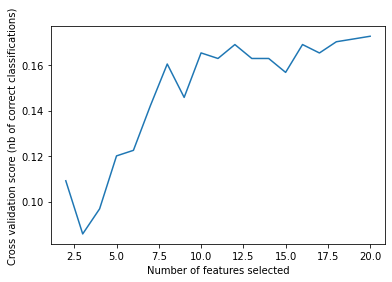

In [150]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [151]:
selected_feats = out.columns[[False] + list(rfecv.get_support()) + [False]*5]
print('selected features:', selected_feats)

selected features: Index(['state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19'],
      dtype='object')


In [152]:
_X2 = rfecv.transform(_X)

In [153]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')

scores = cross_val_score(svc, _X2, y, cv=5)

print('cv acc:', np.mean(scores))
print('random:', 1/len(le.classes_))

cv acc: 0.17275175819242855
random: 0.1


In [154]:
classifier_labels = []
for i,c in enumerate(le.classes_): 
    for j,c2 in enumerate(le.classes_[(i+1):]): 
        classifier_labels.append(f'{c.split("__")[-1]}__VS__{c2.split("__")[-1]}')
#classifier_labels

train score 0.24754901960784315


<Figure size 720x1080 with 0 Axes>

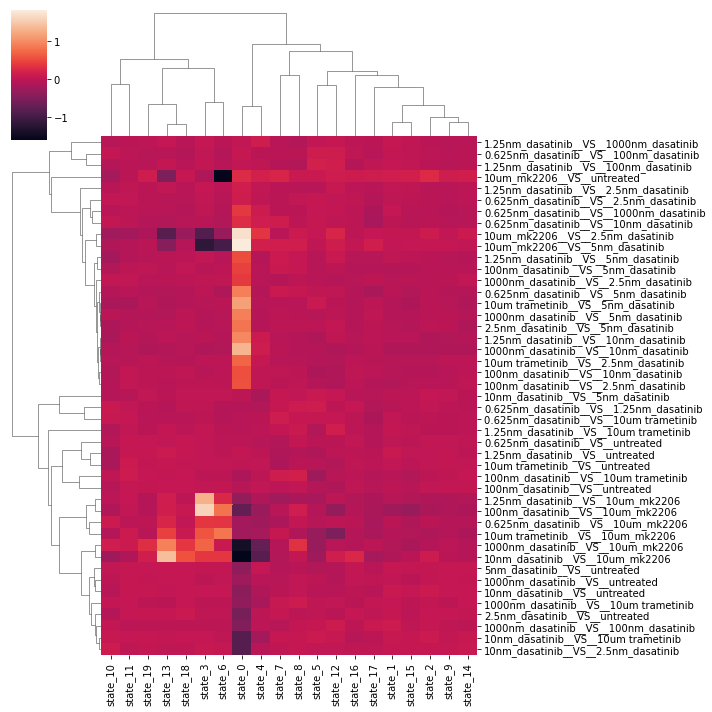

In [155]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
svc.fit(_X2, y)

# https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc
print('train score', svc.score(_X2, y))

plt.figure(figsize=(10,15))
sbn.clustermap(svc.coef_, xticklabels=selected_feats, yticklabels=classifier_labels, metric='correlation')
plt.show()

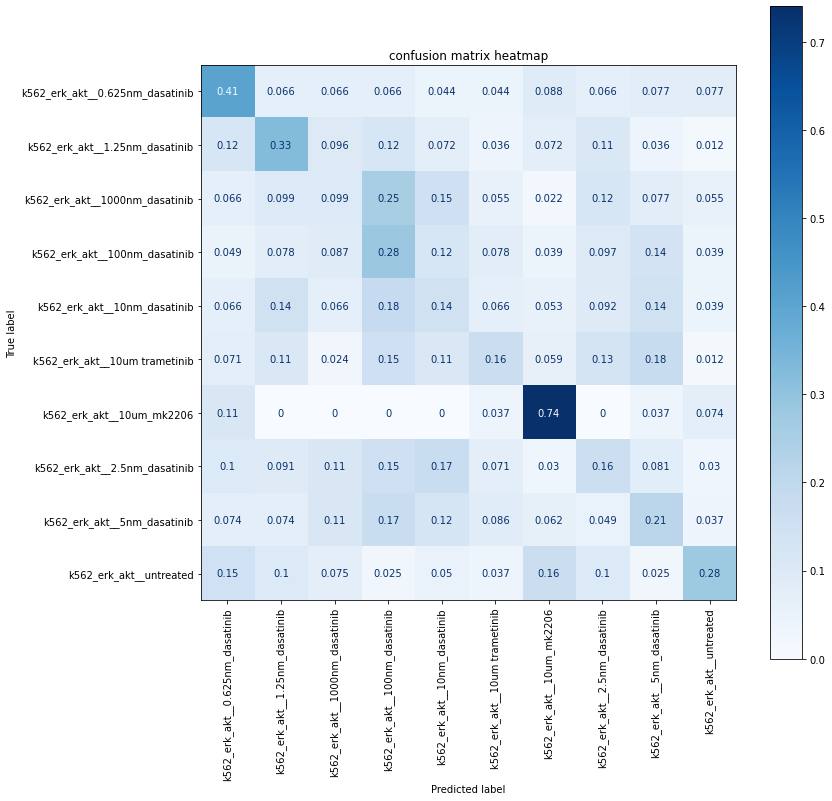

In [156]:
f,ax = plt.subplots(1,1,figsize=(12,12))
plot_confusion_matrix(svc, _X2, y, normalize='true',
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 ax=ax)
plt.xticks(rotation=90)
plt.title('confusion matrix heatmap')
plt.show()

# What does each state look like?

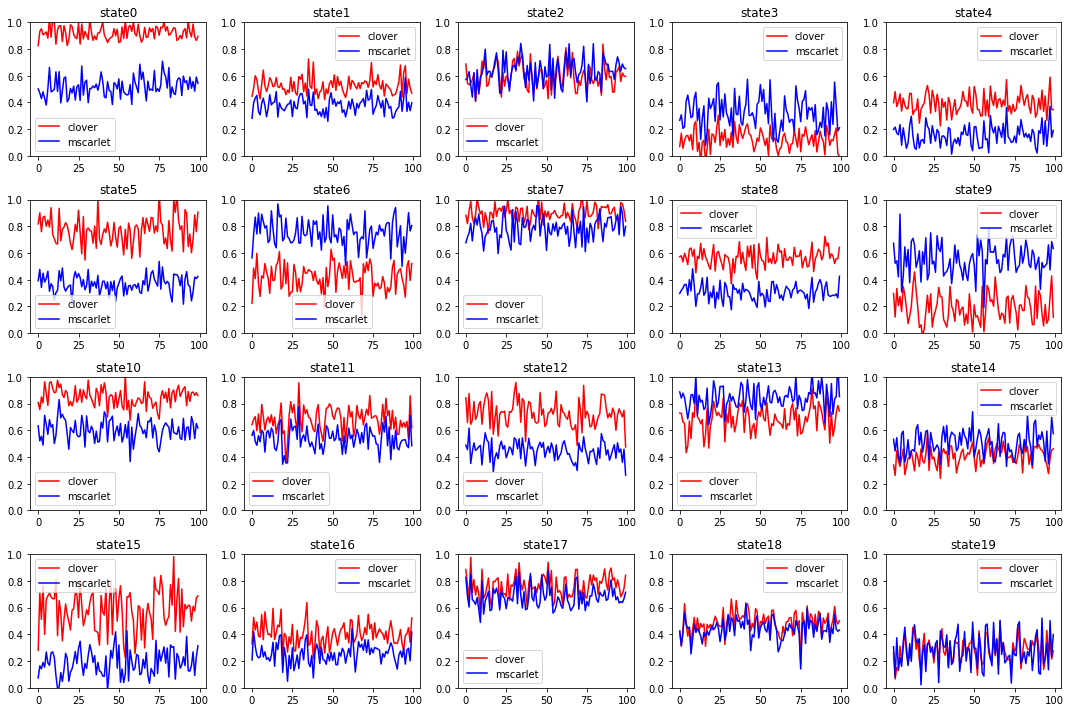

In [170]:
f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(remodel.n_components): 
    x = np.array([remodel._generate_sample_from_state(i) for x in range(100)])
    axes.flat[i].plot(x[:,0], 'r-', label='clover')
    axes.flat[i].plot(x[:, 1], 'b-', label='mscarlet')
    axes.flat[i].set_title('state' + str(i))
    axes.flat[i].set_ylim((0,1))
    axes.flat[i].legend()
plt.tight_layout()
plt.show()

# State transition matrix 

Which states do they jump between most commonly? 

### What is the self-transition probability? Do certain states stay in the same state? or are some states transient? 

Nodes appear to be prodominately uniform in self-transition probability, which makes sense as they are probably determined by the pathway score density. 

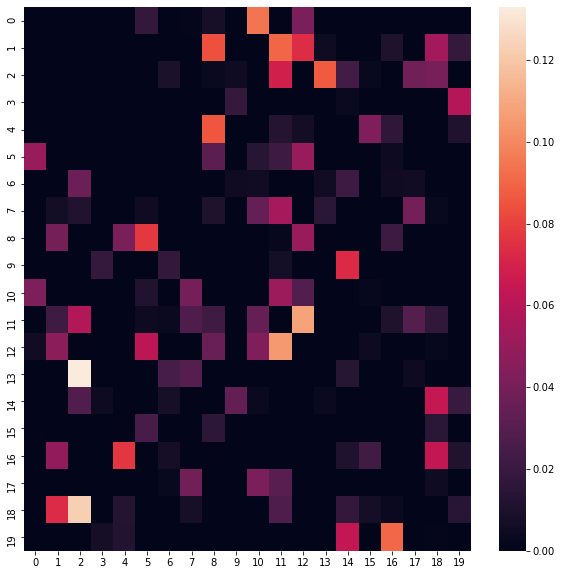

In [171]:
# have to set the diagonal to zero for decent viz (diag is much larger then off diag)
transition_mat = remodel.transmat_.copy()
np.fill_diagonal(transition_mat, 0) #acts *in-place* 

plt.figure(figsize=(10,10))
sbn.heatmap(transition_mat)
plt.show()

75th quantile: 0.006201734592475633


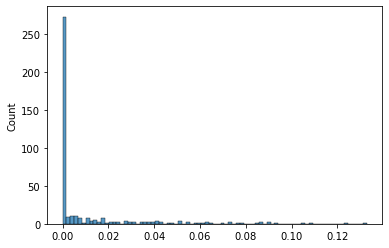

In [172]:
sbn.histplot(transition_mat.flatten())
print('75th quantile:', np.quantile(transition_mat.flatten(), 0.75))

In [160]:
def find_most_common_cycle(A, niters=100): 
    '''
    for niters 
        randomly choose node 
        sample edges with transition probability (excluding self edge)
            record path 
        if new node is original node, break 
    
    count # of unique cycles , choose largest 
    '''
    cycles = {}
    opt = np.arange(A.shape[0])
    i = 0
    for start in np.random.choice(opt, size=niters):
        print(f'progress: {i}/{niters}', end='\r')
        
        nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
        while nxt == start: nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
            
        cycle=[start, nxt]
        while nxt != start: 
            old = nxt
            nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
            if nxt != old: cycle.append(nxt)
        cycle = frozenset(cycle)
        if cycle in cycles:
            cycles[cycle]+=1
        else: 
            cycles[cycle]=1
        i+=1
        
    mcc ={}
    for l in range(2,10): 
        filtered_dict = {k:cycles[k] for k in cycles if len(k)==l}
        try: 
            mcc[l] = max(filtered_dict, key=filtered_dict.get)
        except ValueError: 
            mcc[l]=None
    return mcc
            
_A = remodel.transmat_.copy()
          
mcc = find_most_common_cycle(_A, niters=100000) 
mcc

{2: frozenset({2, 13}),
 3: frozenset({1, 11, 12}),
 4: frozenset({1, 8, 11, 12}),
 5: frozenset({1, 8, 11, 12, 18}),
 6: frozenset({2, 11, 13, 14, 17, 18}),
 7: frozenset({2, 8, 10, 11, 12, 16, 17}),
 8: None,
 9: None}

## Graph Representation of HMM 

> **node size** :  ~self-transition probability    
> **edge width** :  ~transition probability (annotated)   
> **node position** : average state pathway activity (x,y)  
> **node color**:  can be specified, optional: pathway correllation 


TODO: Use `untreated` as the null/base graph. 

In [173]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def plot_hmm(model, ax, threshold=0.65, node_color='r', edge_color='k', label_edge=True, title=None, cbar=True): 
    
    A = model.transmat_.copy() 
        
    # set small values to zero - want sparse graph 
    A[A < np.quantile(A.flatten(), threshold)] = 0 
    
    node_size = 1000*np.diag(A)
    
    G = nx.DiGraph( A )
    
    pos = {i:x for i,x in enumerate(model.means_)}

    edge_weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
    scaled_edge_weights = 10* edge_weights * 1.0/edge_weights.max()
    
    if node_color == 'path-corr':
        corr_mats = np.array([correlation_from_covariance(x) for x in model.covars_])
        node_color = corr_mats[:,0,1] # grab the off diagonal 
        cmap=plt.get_cmap()
        vmin = -1
        vmax = 1
    
        pl = nx.draw_networkx(G, 
                         pos=pos,
                         arrows=True, 
                         **{'node_color':'red',
                         'node_size': node_size,
                         'width': scaled_edge_weights,
                         'arrowstyle': '->',
                         'arrowsize': 35,
                         'node_color':node_color,
                         'edge_color':edge_color,
                         'alpha':1.0,
                         'vmin':vmin,
                         'vmax':vmax}, 
                          ax=ax)
    else: 
        pl = nx.draw_networkx(G, 
                         pos=pos,
                         arrows=True, 
                         **{'node_color':'red',
                         'node_size': node_size,
                         'width': scaled_edge_weights,
                         'arrowstyle': '->',
                         'arrowsize': 35,
                         'node_color':node_color,
                         'edge_color':edge_color,
                         'alpha':1.0}, 
                          ax=ax)
        
    
    if label_edge: 
        labels = nx.get_edge_attributes(G,'weight')
        labels = {k:f'{labels[k]:.3f}' for k in labels}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, ax=ax)
        
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlabel('clover mean (pathway score)', fontsize=15)
    ax.set_ylabel('mscarlet mean (pathway score)', fontsize=15)
    ax.set_title(title)
    
    if (type(node_color) != str) & cbar:
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm, label='correlation')

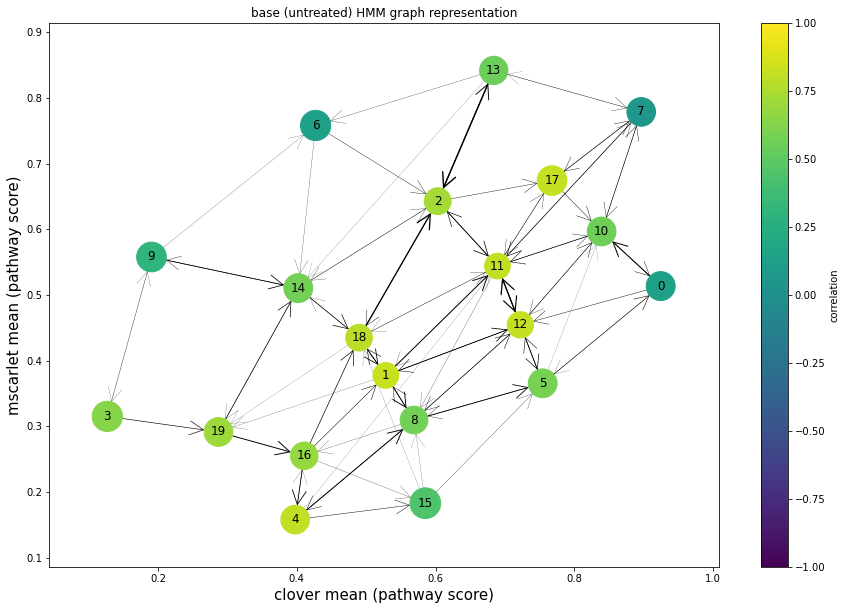

In [175]:
f,ax = plt.subplots(1,1, figsize=(15,10))
plot_hmm(remodel, ax, node_color='path-corr', edge_color='k', label_edge=False, title='base (untreated) HMM graph representation', threshold=0.75)
#lot_hmm_(HMMs[list(HMMs.keys())[1]], ax, node_color='y', edge_color='g', label_edge=False)
plt.show()

In [176]:
# can we find common loops within this? the positional movement here may indicate specific behavior 
# something like the most probable path 

# State Co-variance matrix 

I was curious if any states had co-variance (off diagonal terms - which might indicate correlation between pathway activity)

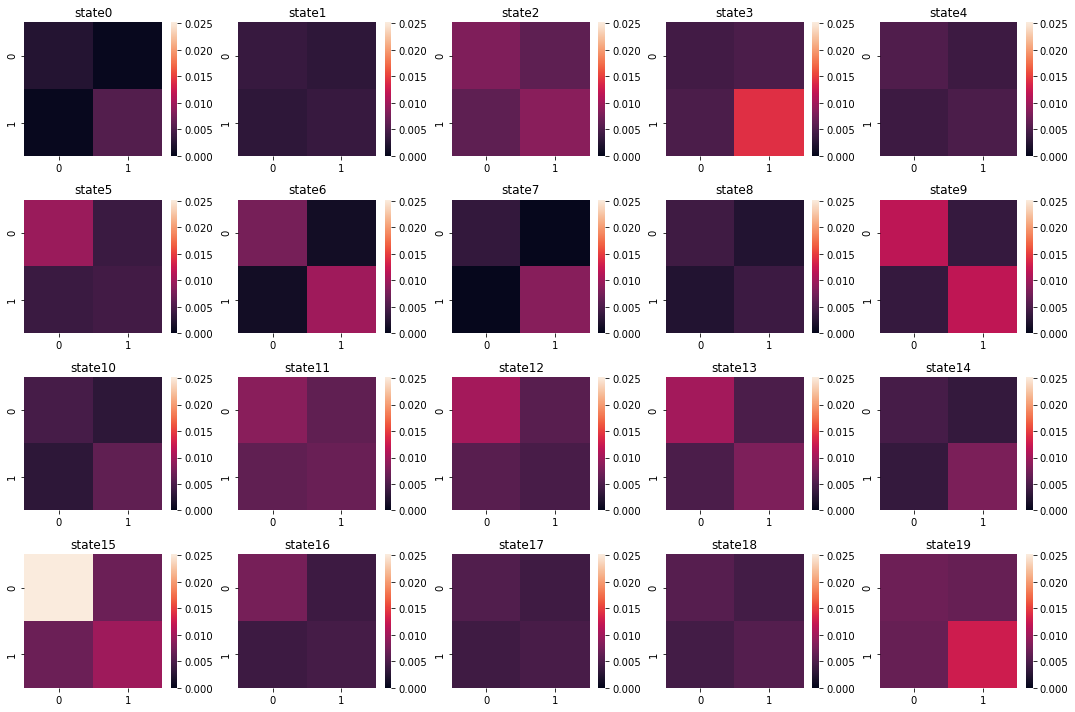

In [177]:
f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(len(axes.flatten())): 
    x = remodel.covars_[i, :, :]
    sbn.heatmap(x, ax=axes.flat[i], vmin=0, vmax=max(remodel.covars_.flatten()))
    axes.flat[i].set_title('state' + str(i))
plt.tight_layout()
plt.show()

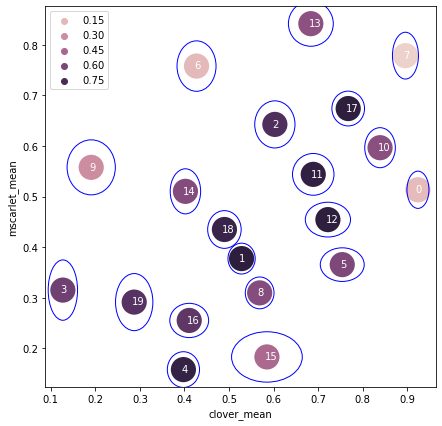

In [178]:
## TODO: add arrow sizes with thickness mediated by transition probabilities. 
## TODO: look at label specific transition probabilities/rates - does this change significnatly??? e.g. do they have different path changes? 


df = pd.DataFrame(remodel.means_, columns=['clover_mean', 'mscarlet_mean']).assign(state=range(remodel.means_.shape[0]))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-0.005, point['y']-0.005, str(int(point['val'])), c='w')
    
def circle_point(x, y, var_x, var_y, ax):
    a = pd.concat({'x': x, 'y': y, 'var_x': var_x, 'var_y':var_y}, axis=1)
    for i, point in a.iterrows():
        elps = Ellipse((point.x, point.y), point.var_x**0.5, point.var_y**0.5, edgecolor='b',facecolor='none')
        ax.add_artist(elps)
        

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

corr_mats = np.array([correlation_from_covariance(x) for x in remodel.covars_])
state_pathway_corr = corr_mats[:,0,1] # grab the off diagonal 

plt.figure(figsize=(7,7))
sbn.scatterplot(x='clover_mean', y='mscarlet_mean', hue=state_pathway_corr, data=df, s=750)       
label_point(df.clover_mean, df.mscarlet_mean, df.state, plt.gca())
circle_point(df.clover_mean, df.mscarlet_mean, pd.Series(remodel.covars_[:,0, 0]), pd.Series(remodel.covars_[:,1, 1]), plt.gca())
plt.show()

In [180]:
# does this orginization correllate to density of time series points? 
plt.figure(figsize=(12,12))
df2 = pd.DataFrame(X, columns=['clover', 'mscarlet'])
sbn.kdeplot(
    data=df2, x="clover", y="mscarlet",
    fill=True, thresh=0, levels=25, cmap="mako",
)
plt.show()

ValueError: Shape of passed values is (816, 20), indices imply (816, 2)

<Figure size 864x864 with 0 Axes>

# Train HMM within each treatment group then compare HMM transition matrices 

In [181]:
HMMs = {}
for treatment in data.cell__treatment.unique(): 
    print('fitting:', treatment)
    temp = data[data.cell__treatment == treatment]
    _x, _lens = form_data(temp)
    HMMs[treatment] = get_HMM(_x, _lens, nstates, niter=niter, means=remodel.means_)
    

fitting: k562_erk_akt__untreated
shape: (4480, 2)
model converged: True
fitting: k562_erk_akt__0.625nm_dasatinib
shape: (5096, 2)
model converged: True
fitting: k562_erk_akt__1.25nm_dasatinib
shape: (4648, 2)
model converged: True
fitting: k562_erk_akt__2.5nm_dasatinib
shape: (5544, 2)
model converged: True
fitting: k562_erk_akt__5nm_dasatinib
shape: (4536, 2)
model converged: True
fitting: k562_erk_akt__10nm_dasatinib
shape: (4256, 2)
model converged: True
fitting: k562_erk_akt__100nm_dasatinib
shape: (5768, 2)
model converged: True
fitting: k562_erk_akt__1000nm_dasatinib
shape: (5096, 2)
model converged: True
fitting: k562_erk_akt__10um trametinib
shape: (4760, 2)
model converged: True
fitting: k562_erk_akt__10um_mk2206
shape: (1512, 2)
model converged: True


In [182]:
def comparative_graph_plots(model1, model2, treatment): 
    f,axes = plt.subplots(1,2, figsize=(20,7), sharex=True, sharey=True)
    plot_hmm(model1, axes[0], node_color='path-corr', edge_color='k', label_edge=False, title=f'{treatment} HMM', threshold=0.8)
    
    plot_hmm(model2, axes[1], node_color='path-corr', edge_color='k', label_edge=False, title='base (untreated) HMM graph representation', cbar=False, threshold=0.8)

    plt.show()
    
def plot_trans(mat, ax, title): 
    mat = mat.copy()
    np.fill_diagonal(mat, 0)
    sbn.heatmap(mat, ax=ax)
    ax.set_title(title)
    
def comparative_transition_heatmaps(model1, model2, treatment): 
    
    f,axes = plt.subplots(1,2, figsize=(20,7))
    
    plot_trans(model1.transmat_, axes.flat[1], 'base (untreated)')
    
    plot_trans(model2.transmat_, axes.flat[0], treatment)

    plt.show()

def model_comparison(model1, model2, treatment): 
    
    f,axes = plt.subplots(1,2, figsize=(20,7))
    
    # plot graphs overlapping
    plot_hmm(model1, axes[0], node_color='b', edge_color='b', label_edge=False, threshold=0.8)
    
    plot_hmm(model2, axes[0], node_color='r', edge_color='r', label_edge=False, title=f'base_HMM=red | {treatment}=blue', cbar=False, threshold=0.8)

    # plot trans mat DIFFERENCES
    
    plot_trans(model2.transmat_.copy() - model1.transmat_.copy(), axes.flat[1], f'transmat DIFF ({treatment} vs untreated)')

    plt.show()

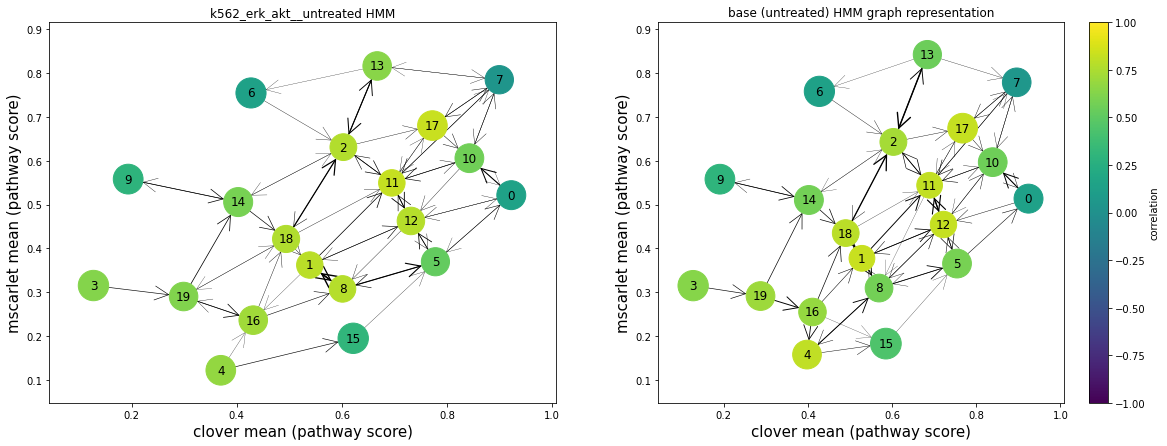

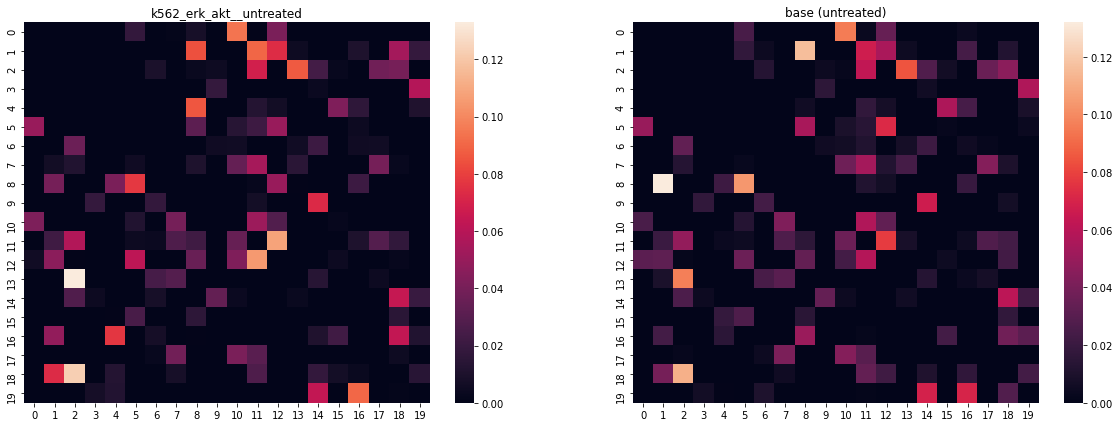

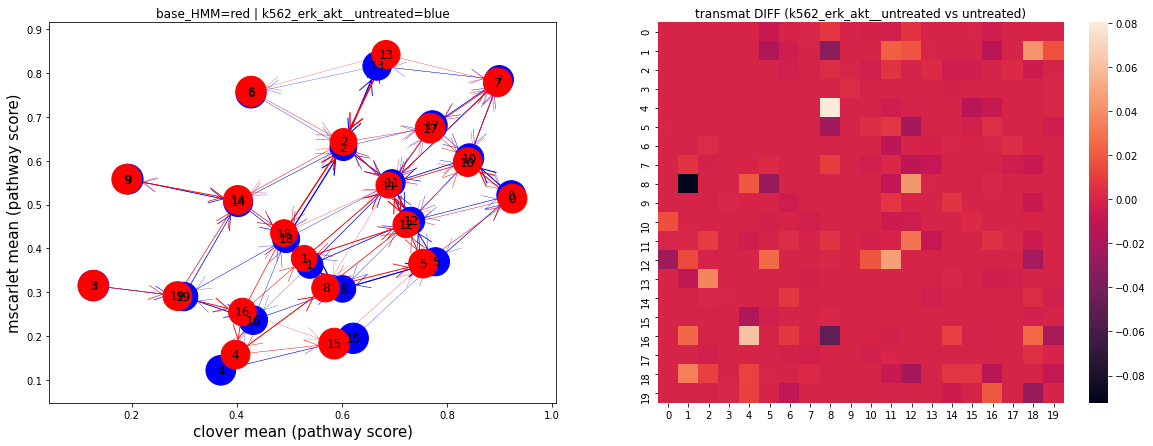

####################################################################################################
####################################################################################################


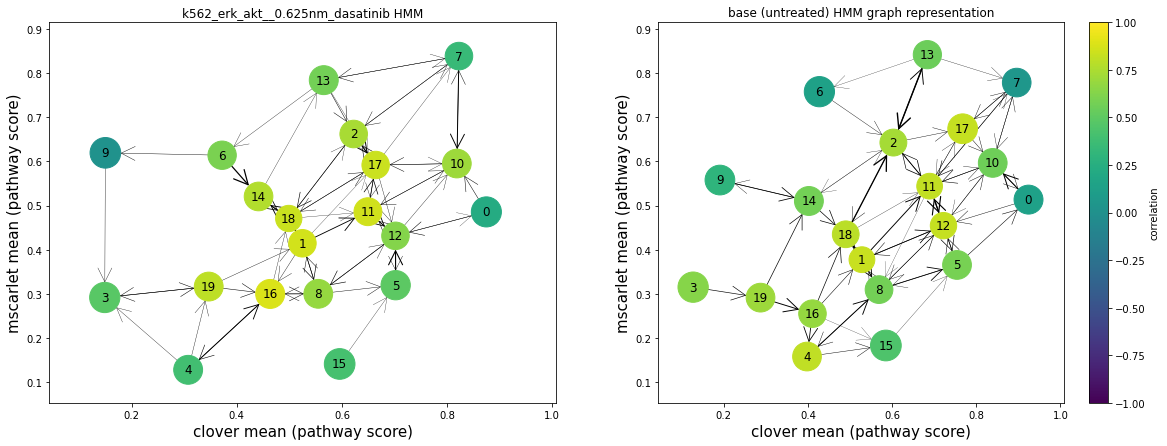

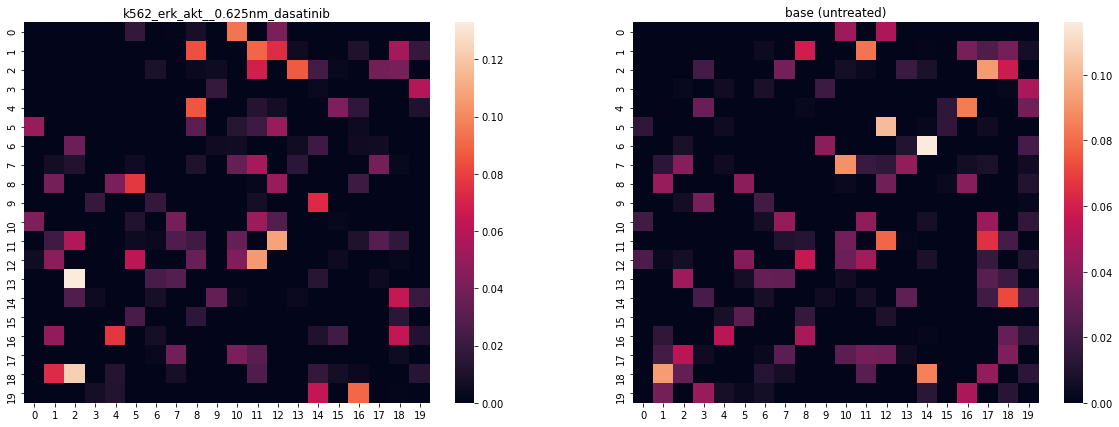

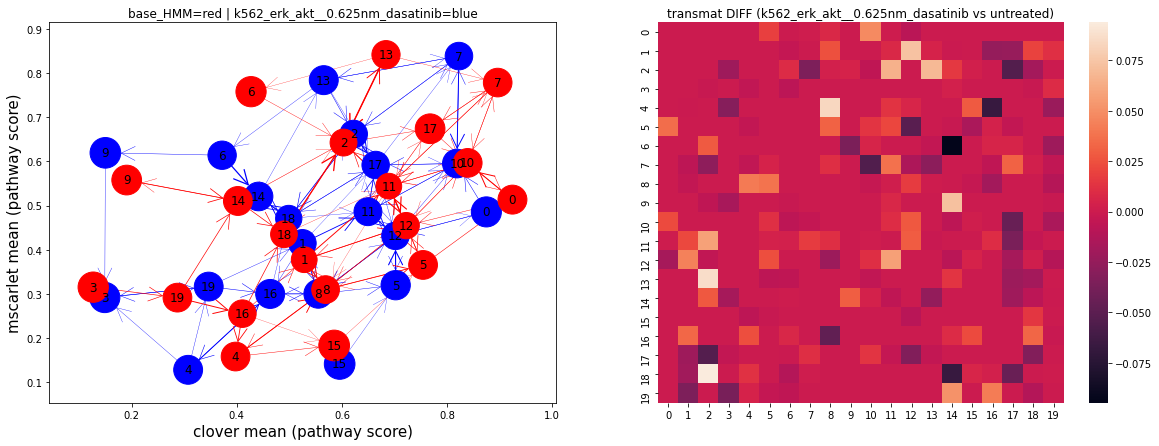

####################################################################################################
####################################################################################################


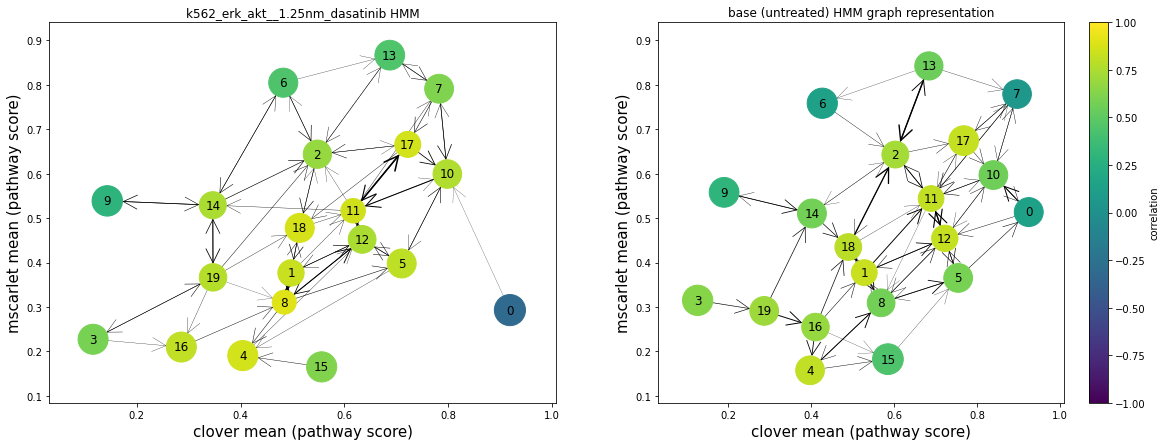

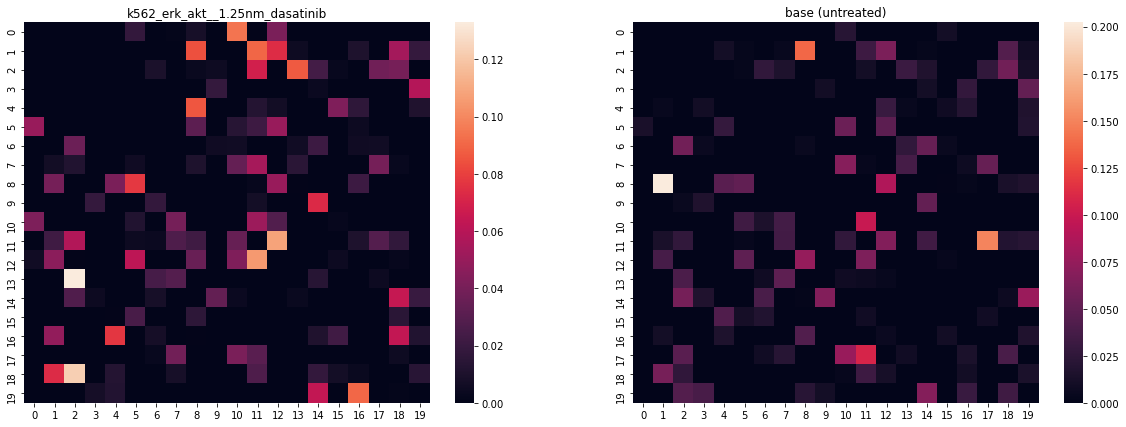

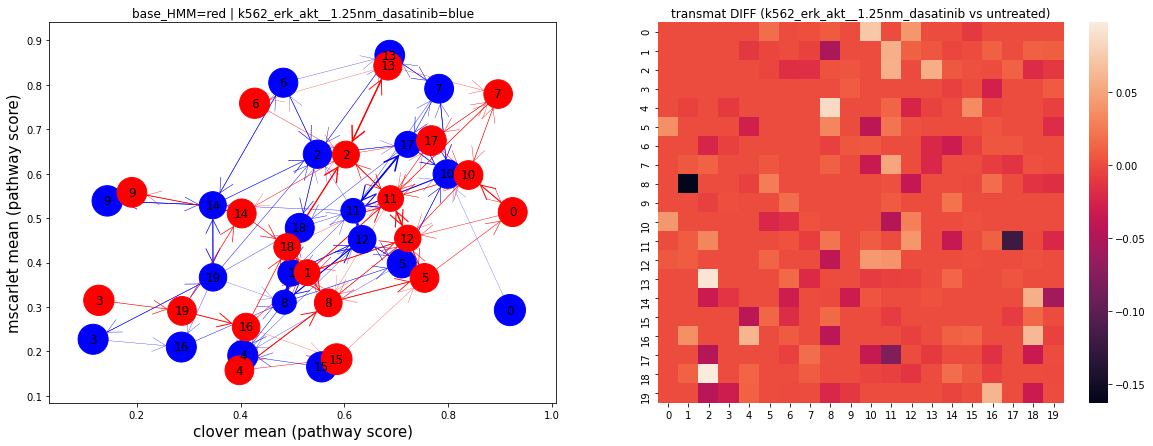

####################################################################################################
####################################################################################################


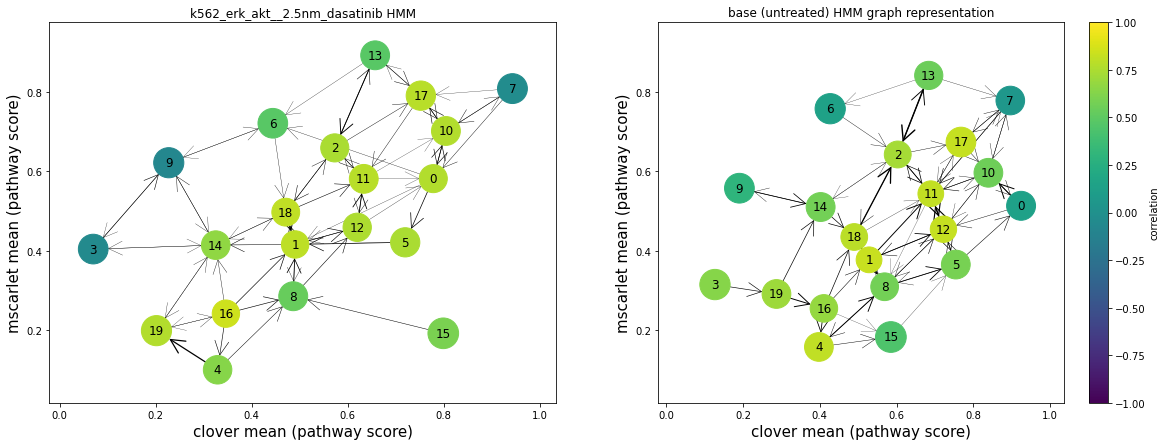

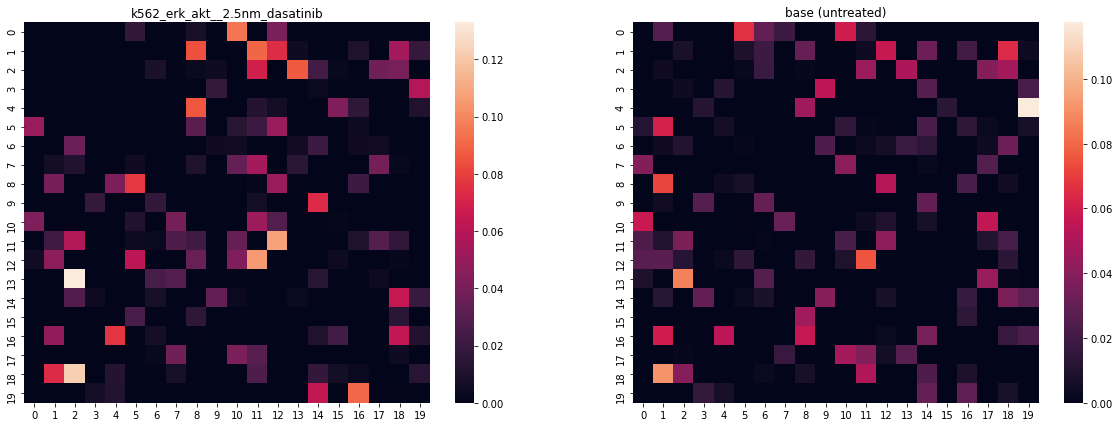

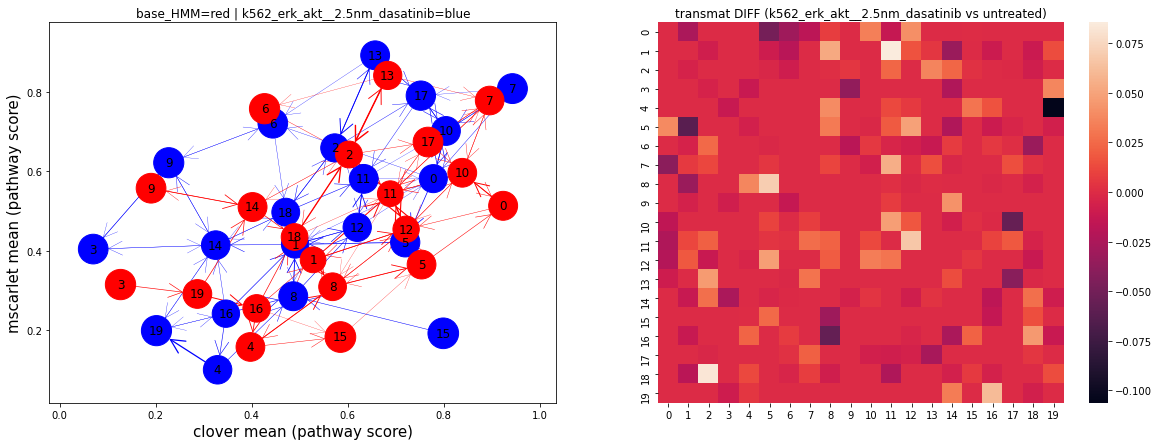

####################################################################################################
####################################################################################################


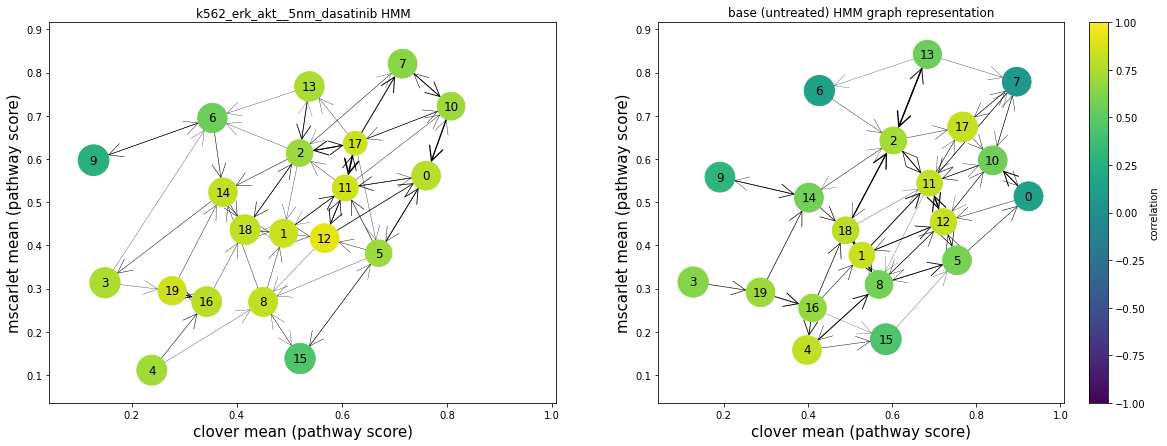

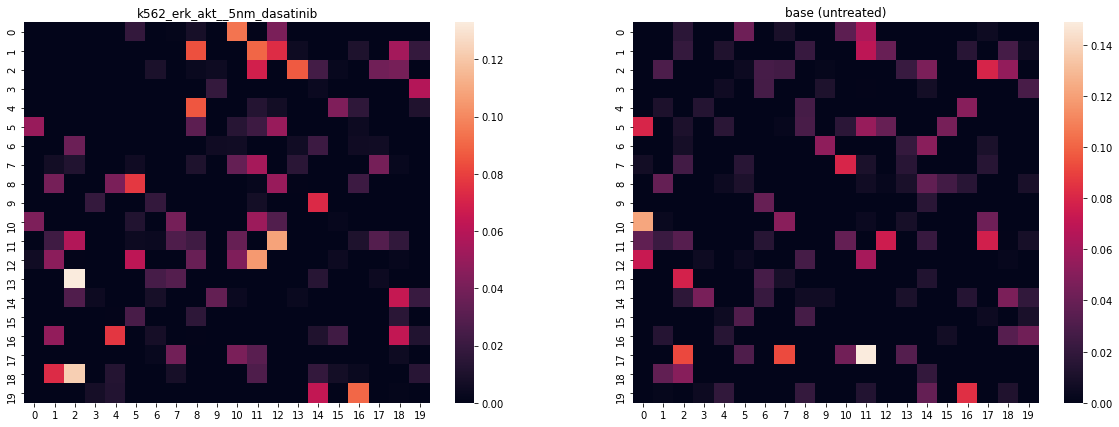

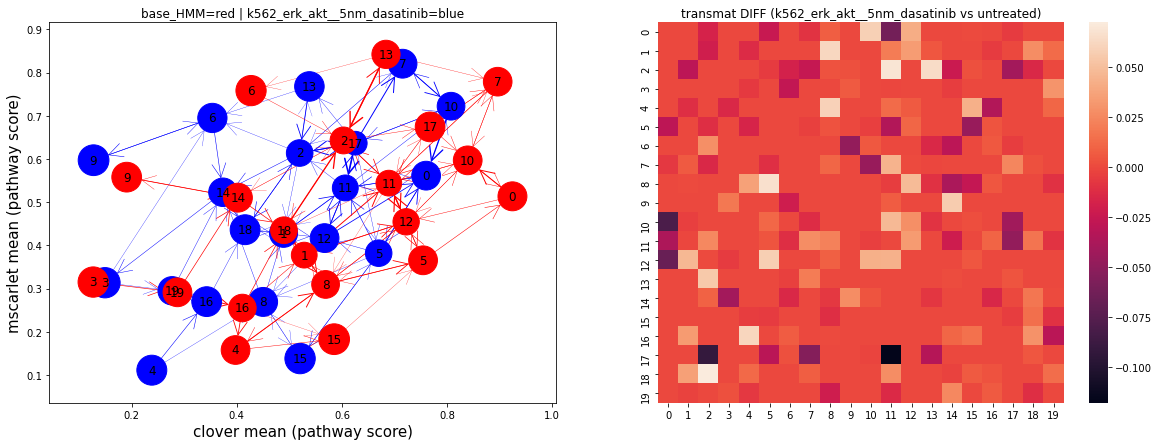

####################################################################################################
####################################################################################################


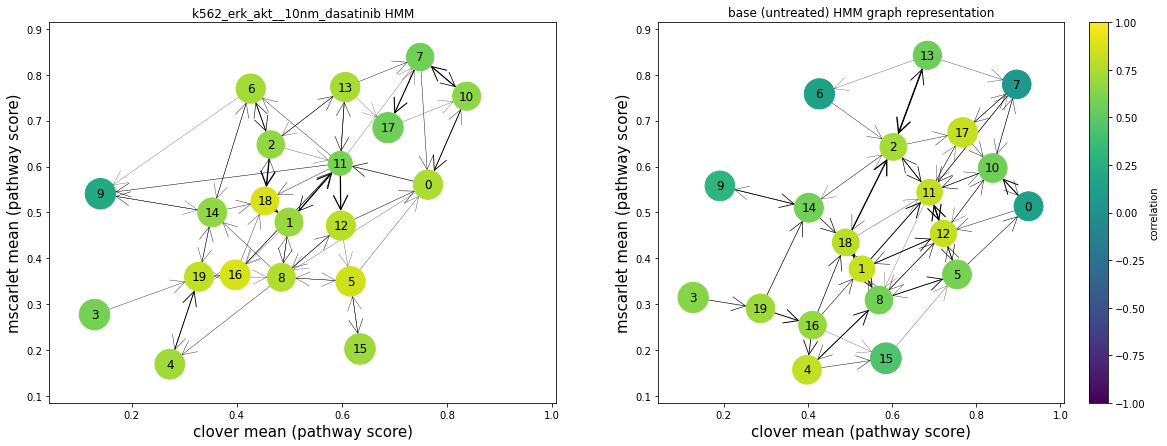

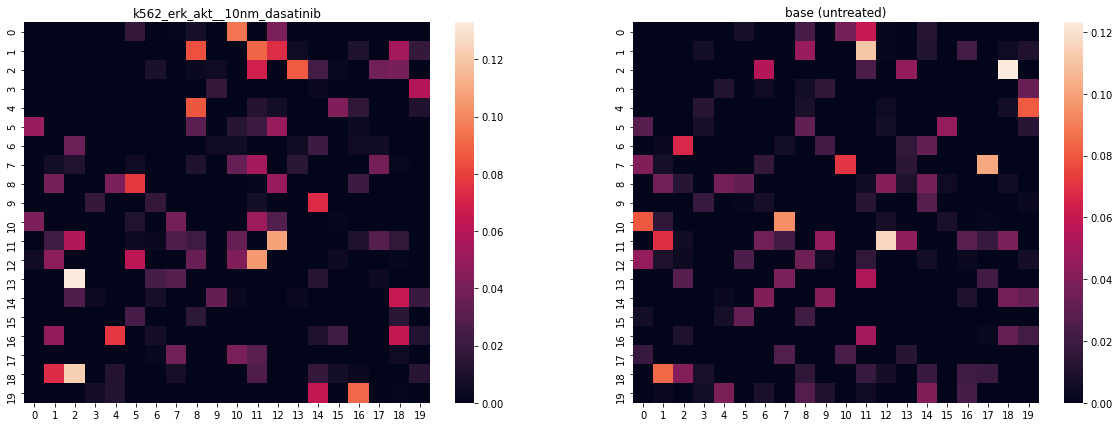

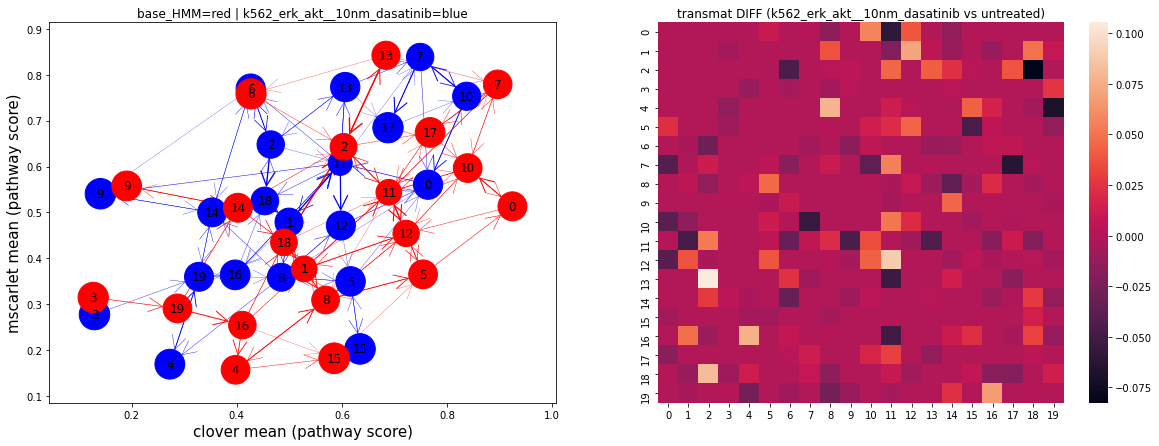

####################################################################################################
####################################################################################################


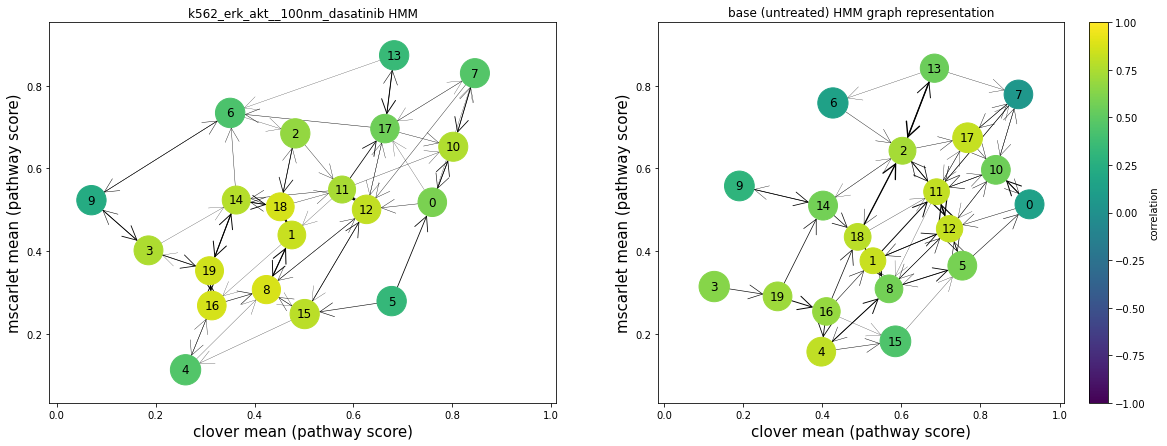

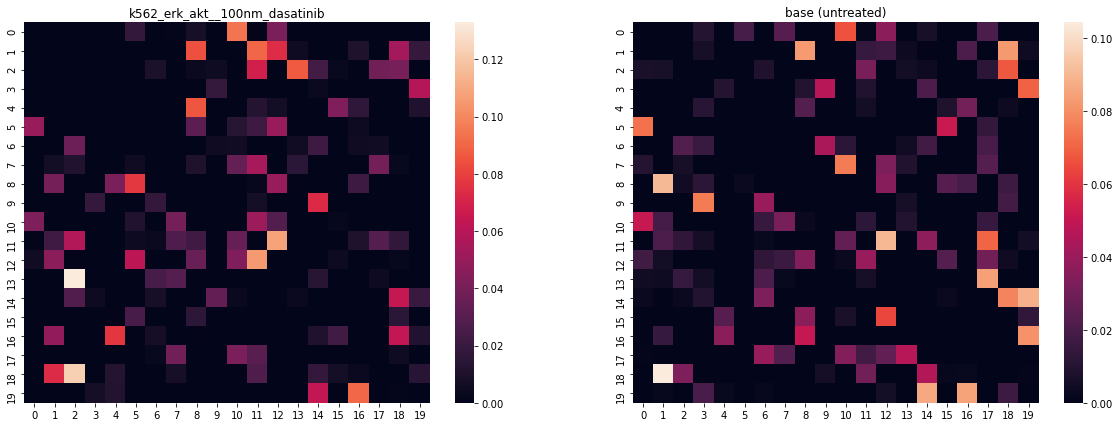

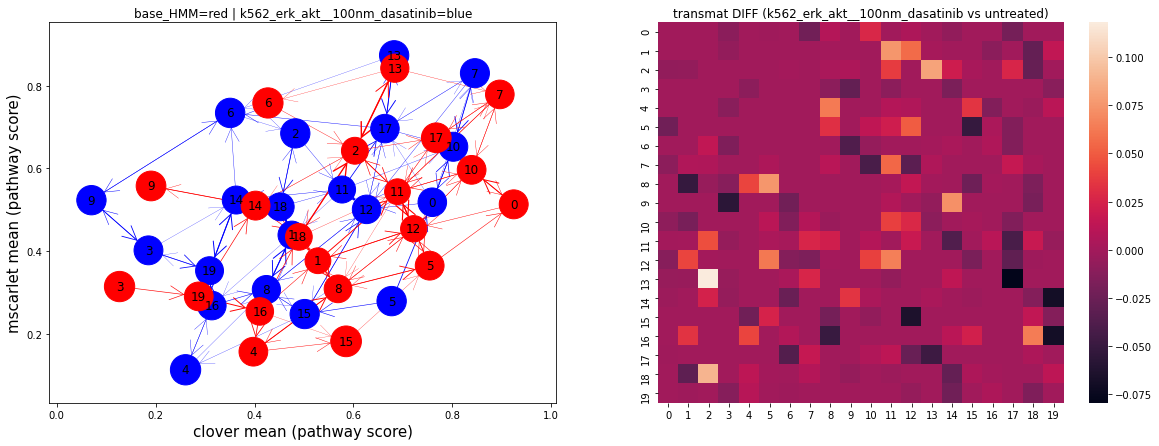

####################################################################################################
####################################################################################################


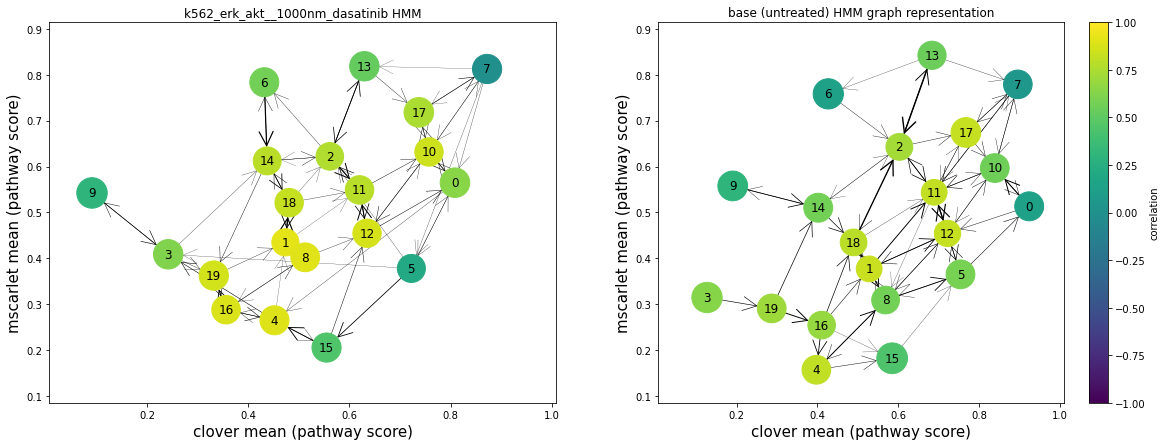

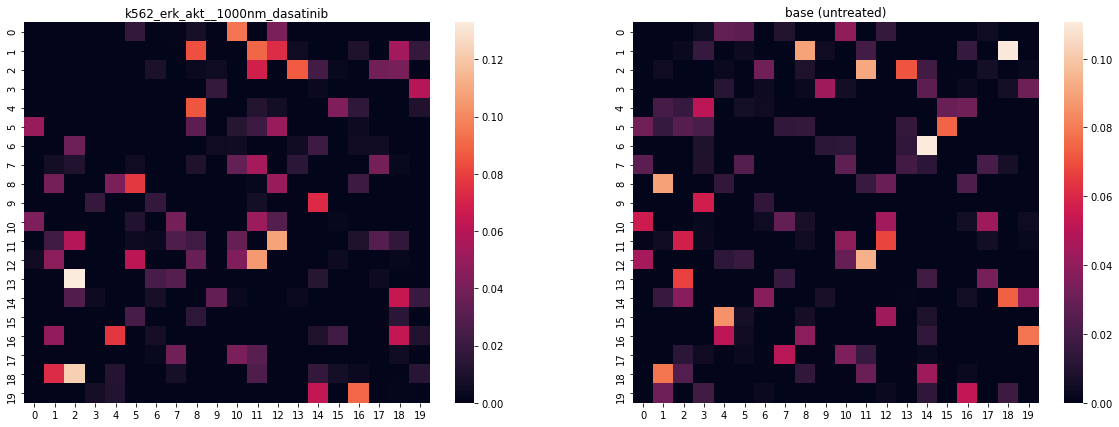

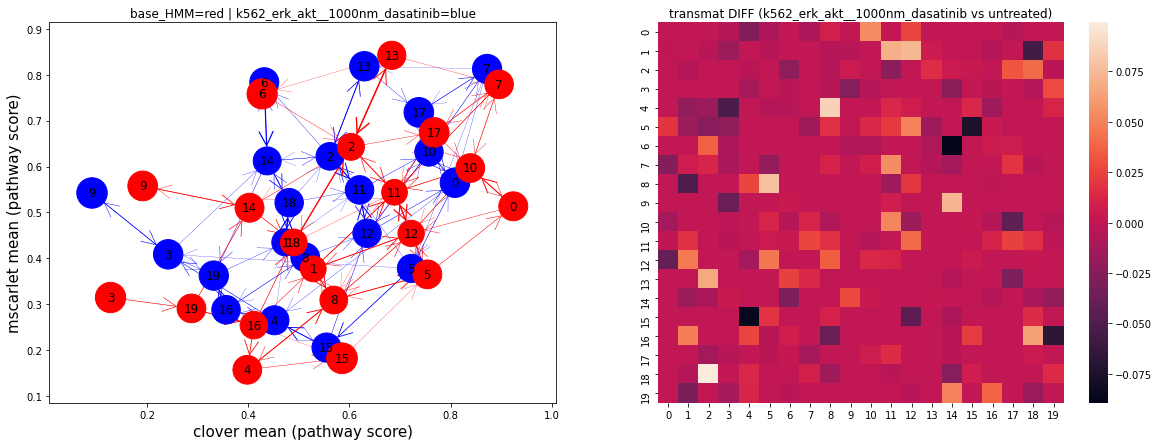

####################################################################################################
####################################################################################################


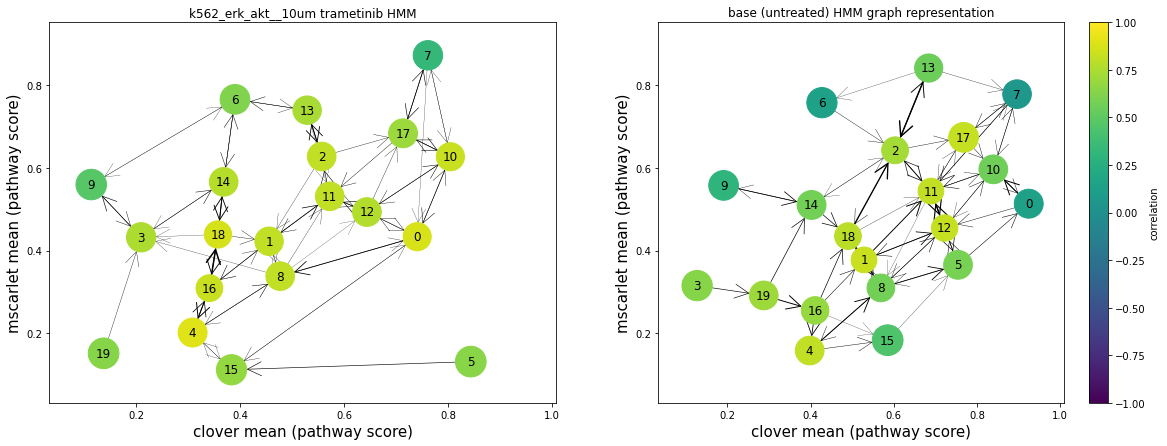

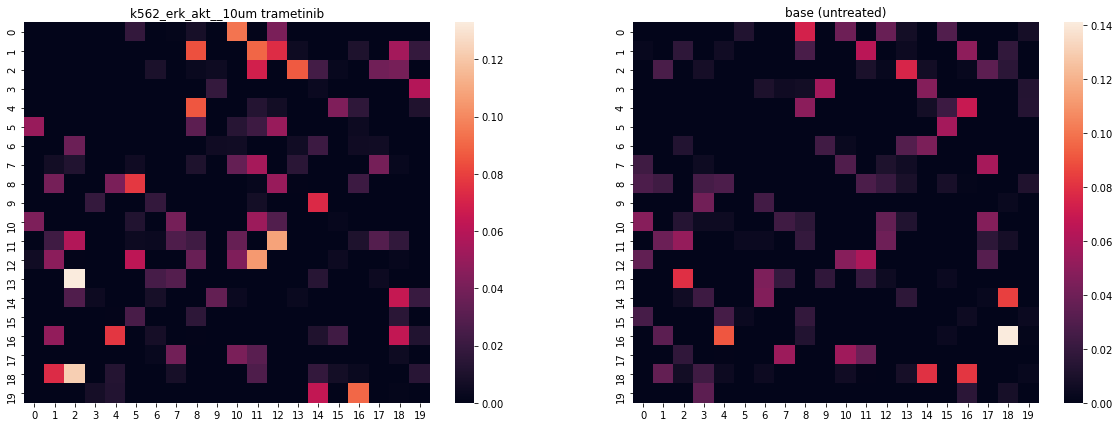

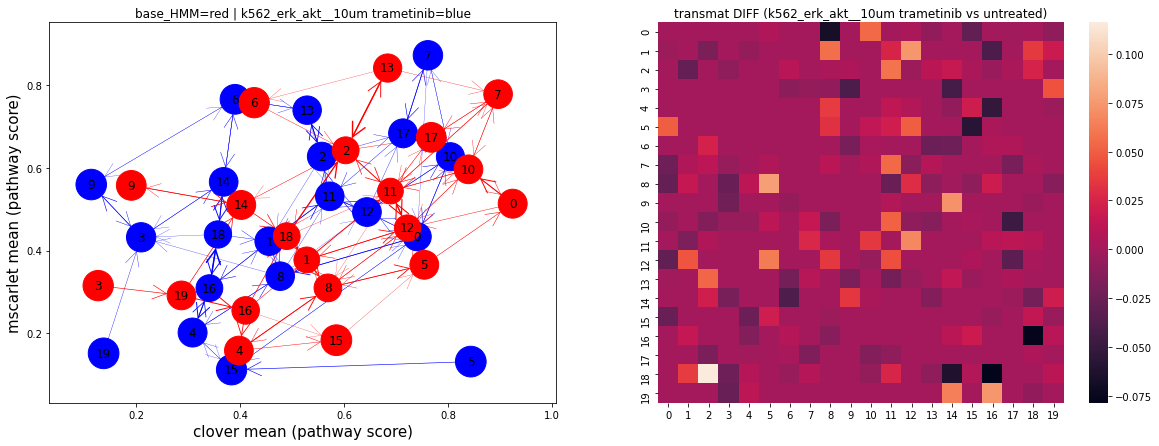

####################################################################################################
####################################################################################################


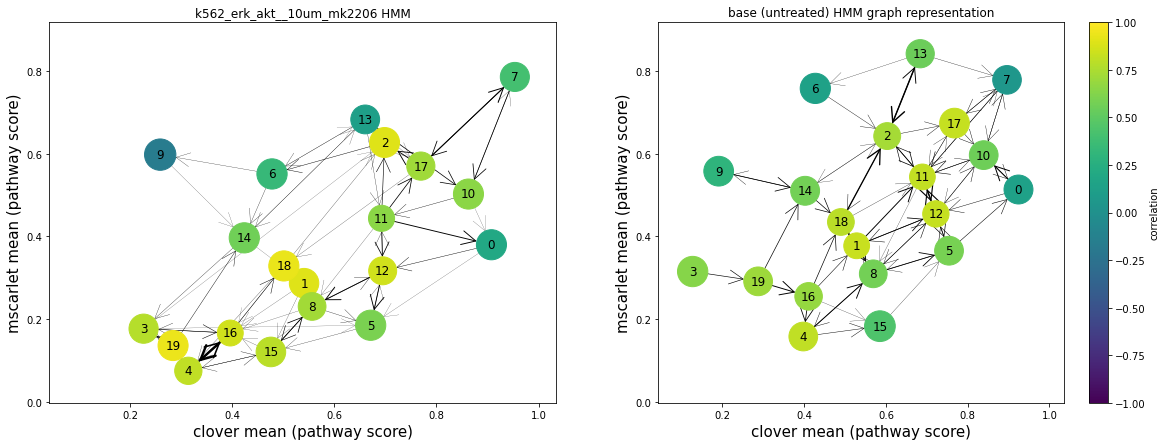

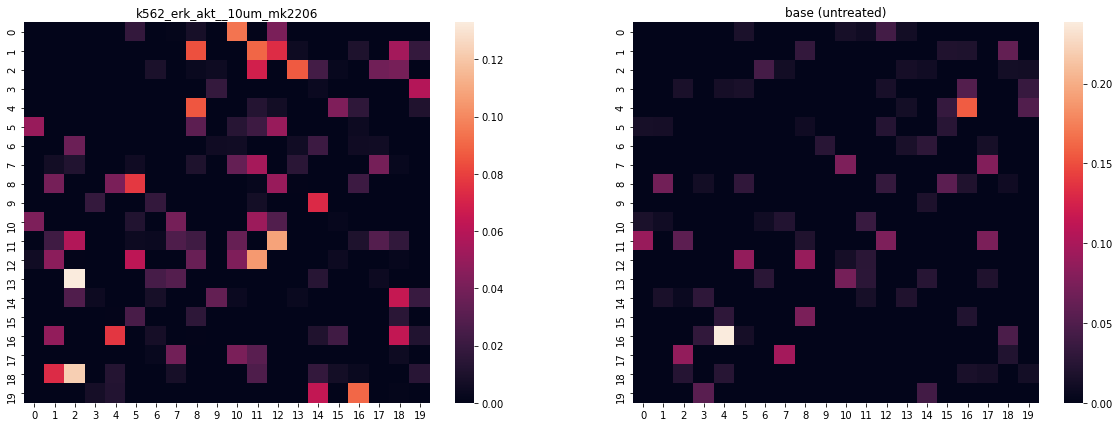

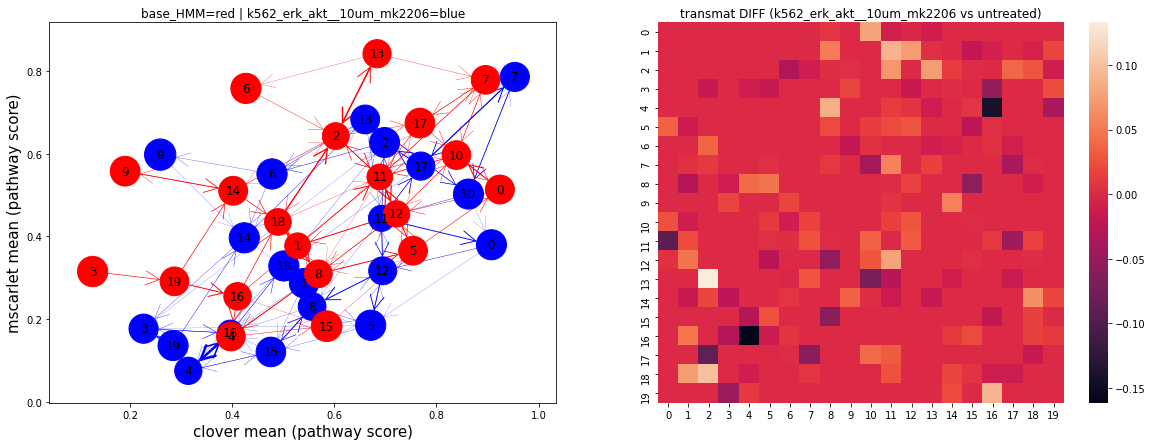

####################################################################################################
####################################################################################################


In [183]:
for treatment in HMMs: 
    comparative_graph_plots(HMMs[treatment], remodel, treatment)
    comparative_transition_heatmaps(HMMs[treatment], remodel, treatment)
    model_comparison(HMMs[treatment], remodel, treatment)
    print('#'*100)
    print('#'*100)

## can we use the transition matrix as features? 

In [185]:
_transdat = [HMMs[treatment].transmat_.flatten() for treatment in HMMs.keys()]
df = pd.DataFrame(_transdat).assign(treatment=HMMs.keys())
df.head()

0             1             2              3              4  \
0  0.837151  2.175781e-31  5.533245e-57   0.000000e+00   3.039401e-78   
1  0.904105  2.633565e-47  5.978065e-41  1.477266e-113   2.922062e-45   
2  0.968453  1.548751e-87  1.375397e-71  2.856211e-283  3.059408e-130   
3  0.786268  2.494191e-02  6.992537e-19   3.265972e-34   5.386415e-52   
4  0.826641  8.488206e-22  1.718924e-02   1.727447e-50   2.422553e-28   

              5              6             7             8              9  \
0  2.504597e-02  3.979184e-134  3.571270e-04  5.445648e-13  2.997139e-182   
1  1.532152e-13   4.039526e-88  6.940352e-08  3.402673e-18  7.707472e-217   
2  3.590275e-06   1.979113e-91  1.267357e-70  5.516167e-60  1.431755e-303   
3  6.657378e-02   3.007729e-02  1.871898e-02  5.410540e-08   1.822599e-27   
4  4.233216e-02   2.015817e-26  9.981157e-03  4.121287e-29   1.293566e-75   

   ...           391           392            393       394            395  \
0  ...  1.230050e-03  1.457337e-41   6.128099e-50  0.069466   2.655689e-35   
1  ...  2.747320e-28  5.013707e-11   2.075996e-45  0.012716   1.679044e-95   
2  ...  3.244575e-17  1.293311e-31   2.186837e-61  0.067592   1.200930e-83   
3  ...  1.451945e-50  2.123310e-35  1.406083e-181  0.030913  5.012448e-172   
4  ...  1.379570e-02  1.135559e-46   8.510676e-83  0.038617   4.374023e-71   

        396            397       398       399  \
0  0.070279   1.687221e-59  0.027966  0.813507   
1  0.048552   1.244218e-13  0.012443  0.830771   
2  0.030504   2.052113e-40  0.033936  0.752853   
3  0.029174  1.392097e-143  0.007820  0.908555   
4  0.083707   2.541487e-36  0.012470  0.804570   

                         treatment  
0          k562_erk_akt__untreated  
1  k562_erk_akt__0.625nm_dasatinib  
2   k562_erk_akt__1.25nm_dasatinib  
3    k562_erk_akt__2.5nm_dasatinib  
4      k562_erk_akt__5nm_dasatinib  

[5 rows x 401 columns]

<AxesSubplot:ylabel='Count'>

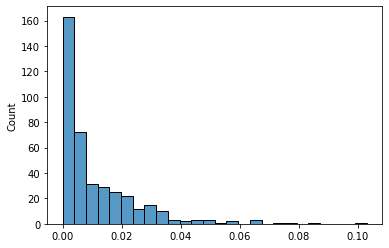

In [186]:
sbn.histplot(df[df.columns[:-1]].values.std(axis=0))

In [187]:
high_var_feats = df.columns[list(df[df.columns[:-1]].values.std(axis=0) > 0.01) + [True]]
high_var_feats

Index([          0,           5,           8,          10,          11,
                12,          21,          28,          31,          32,
       ...
               381,         382,         383,         384,         388,
               394,         396,         398,         399, 'treatment'],
      dtype='object', length=145)

In [188]:
df2 = df[high_var_feats]
X = df2.values[:,:-1]

In [189]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X2 = pca.transform(X)

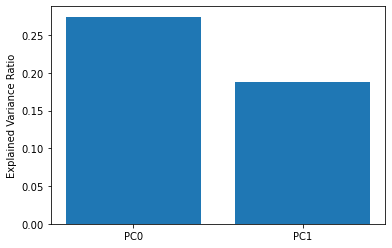

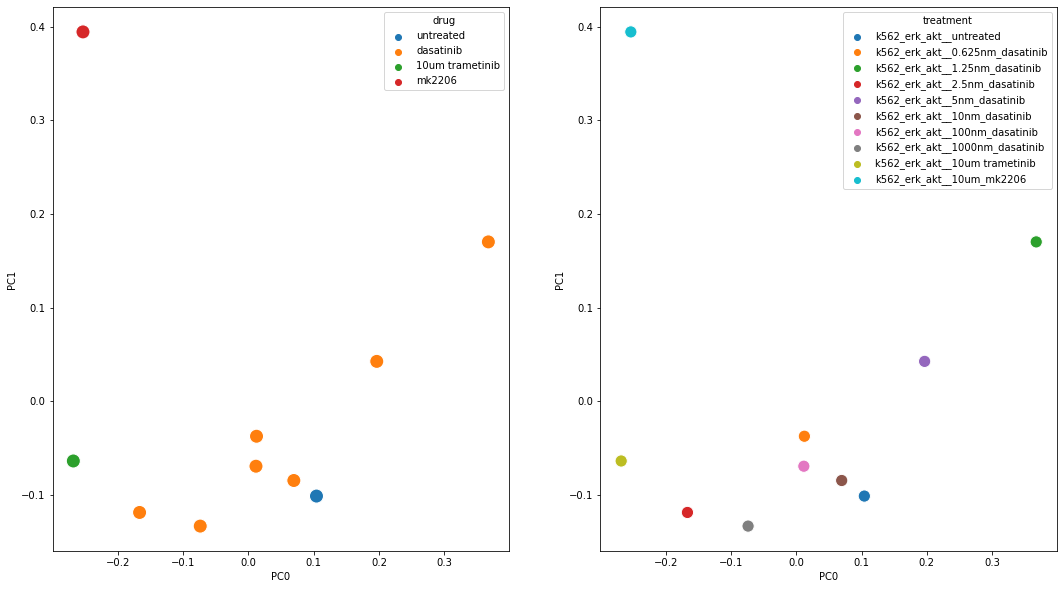

In [190]:
# TODO: Global color assignment 0 nicety 

df3 = pd.DataFrame(X2, columns=['PC0', 'PC1']).assign(treatment=df2.treatment)
df3 = df3.assign(drug = [x.split('_')[-1] for x in df2.treatment])

plt.figure()
plt.bar(height=pca.explained_variance_ratio_, x=['PC0', 'PC1'])
plt.ylabel('Explained Variance Ratio')
plt.show()

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=df3, ax=axes[0], s=200)
sbn.scatterplot(x='PC0', y='PC1', hue='treatment', data=df3, ax=axes[1], s=150)
plt.show()

# Analysis 2: Time-series Feature Extraction 

documentation: https://tsfel.readthedocs.io/en/latest/  

paper: https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [191]:

# needs to be column delineated 
# time-id  feature 
obs = []
for i, row in data.iterrows(): 
    obs.append(pd.DataFrame({'clover':row[data.attrs['clover_selector']].values, 'mscarlet':row[data.attrs['mscarlet_selector']].values, 'time(h)':[x.split('=')[-1] for x in data.attrs['clover_selector']]}))

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()
                                          
# Extract features
X = []
for i,o in enumerate(obs): 
    print(f'progress: {i}/{len(obs)}', end='\r')
    X.append(tsfel.time_series_features_extractor(cfg, o, verbose=False))

<ipython-input-191-0536f27c8418>:14: UserWarning: Using default sampling frequency set in configuration file.
  X.append(tsfel.time_series_features_extractor(cfg, o, verbose=False))


In [192]:
res = pd.concat(X, axis=0).reset_index(drop=True)
res = res.assign(track_index=data.track_index, cell__treatment=data.cell__treatment)
res.head()

0_Absolute energy  0_Area under the curve  0_Autocorrelation  0_Centroid  \
0          41.081167                0.465164          41.081167    0.307603   
1          41.266724                0.468248          41.266724    0.306165   
2          39.713090                0.459819          39.713090    0.290662   
3          36.876131                0.440208          36.876131    0.252384   
4          35.694241                0.433236          35.694241    0.312251   

   0_ECDF Percentile Count_0  0_ECDF Percentile Count_1  0_ECDF Percentile_0  \
0                       11.0                       44.0             0.777096   
1                       11.0                       44.0             0.758044   
2                       11.0                       44.0             0.782360   
3                       11.0                       44.0             0.685817   
4                       11.0                       44.0             0.621023   

   0_ECDF Percentile_1  0_ECDF Slope  0_ECDF_0  ...  2_Wavelet variance_2  \
0             0.955623      3.608703  0.017857  ...             10.665514   
1             0.955166      3.893386  0.017857  ...             10.665514   
2             0.917580      4.453743  0.017857  ...             10.665514   
3             0.892235      5.303727  0.017857  ...             10.665514   
4             0.884866      7.106138  0.017857  ...             10.665514   

   2_Wavelet variance_3  2_Wavelet variance_4  2_Wavelet variance_5  \
0             19.070369             30.135337             44.038737   
1             19.070369             30.135337             44.038737   
2             19.070369             30.135337             44.038737   
3             19.070369             30.135337             44.038737   
4             19.070369             30.135337             44.038737   

   2_Wavelet variance_6  2_Wavelet variance_7  2_Wavelet variance_8  \
0             60.935727             80.675345            102.356581   
1             60.935727             80.675345            102.356581   
2             60.935727             80.675345            102.356581   
3             60.935727             80.675345            102.356581   
4             60.935727             80.675345            102.356581   

   2_Zero crossing rate                            track_index  \
0                   1.0  78_1000101697_k562_erk_akt__untreated   
1                   1.0  77_1000098381_k562_erk_akt__untreated   
2                   1.0   4_1000007026_k562_erk_akt__untreated   
3                   1.0   2_1000002957_k562_erk_akt__untreated   
4                   1.0  82_1000111191_k562_erk_akt__untreated   

           cell__treatment  
0  k562_erk_akt__untreated  
1  k562_erk_akt__untreated  
2  k562_erk_akt__untreated  
3  k562_erk_akt__untreated  
4  k562_erk_akt__untreated  

[5 rows x 491 columns]

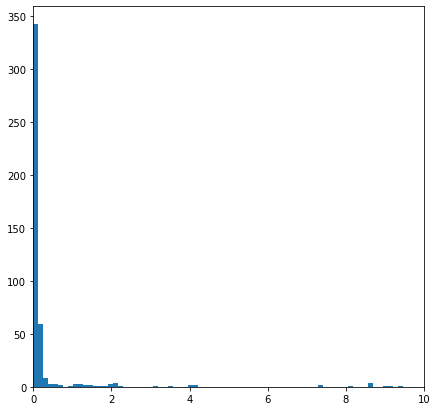

In [193]:
plt.figure(figsize=(7,7))
plt.hist(np.std(res[res.columns[:-2]], axis=0), bins=1000)
plt.xlim(0,10)
plt.show()

In [194]:
# variance filter 
print(res.shape)
res2 = res[res.columns[(np.std(res[res.columns[:-2]], axis=0) > 0.).values.tolist() + [True, True]]]
res2.shape

(816, 491)


(816, 437)

## Recursive Feature Elimination 

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [196]:
X = res2[res2.columns[:-2]].values
y = res2.cell__treatment.values

le = preprocessing.LabelEncoder()
le.fit(y)
y2 = le.transform(y)
#le.inverse_transform([0, 0, 1, 2])

scaler = StandardScaler()
X2 = scaler.fit_transform(X)

In [198]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 10  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy',
              min_features_to_select=min_features_to_select, verbose=False, n_jobs=8)
rfecv.fit(X2, y2)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 17


In [213]:
print('selected features:')
_ = [print(x) for x in res2.columns[list(rfecv.get_support()) + [False, False]]]

selected features:
0_FFT mean coefficient_1
0_Histogram_5
0_Interquartile range
0_Max
0_Median frequency
0_Slope
0_Spectral decrease
0_Spectral skewness
0_Spectral slope
0_Wavelet absolute mean_0
0_Wavelet absolute mean_2
1_Centroid
1_Histogram_5
1_Median absolute diff
1_Slope
1_Wavelet standard deviation_8
1_Wavelet variance_0


In [204]:
X3 = rfecv.transform(X2)

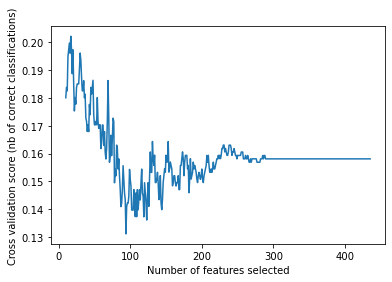

In [205]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [207]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')

scores = cross_val_score(svc, X3, y2, cv=10)

print('cv acc:', np.mean(scores))
print('random:', 1/len(le.classes_))

cv acc: 0.2070460704607046
random: 0.1


In [208]:
classifier_labels = []
for i,c in enumerate(le.classes_): 
    for j,c2 in enumerate(le.classes_[(i+1):]): 
        classifier_labels.append(f'{c.split("__")[-1]}__VS__{c2.split("__")[-1]}')
#classifier_labels

train score 0.30637254901960786


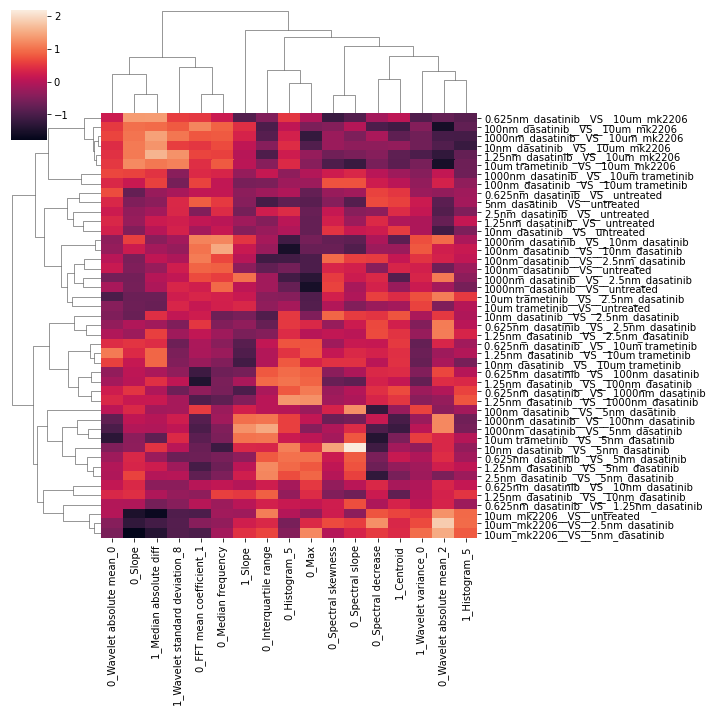

In [209]:

svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
svc.fit(X3, y2)

# https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc
print('train score', svc.score(X3, y2))

sbn.clustermap(svc.coef_, xticklabels=res2.columns[list(rfecv.get_support()) + [False, False]], yticklabels=classifier_labels, metric='correlation')
#f_importances(svc.coef_, res2.columns[list(rfecv.get_support()) + [False, False]])

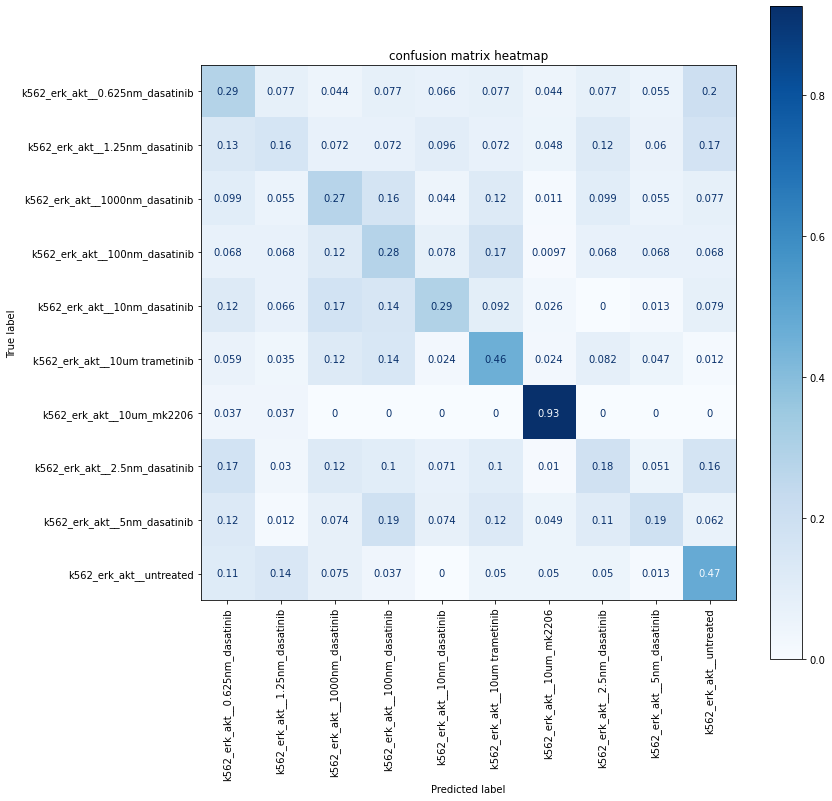

In [211]:
f, ax = plt.subplots(1,1,figsize=(12,12))
plot_confusion_matrix(svc, X3, y2, normalize='true',
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.title('confusion matrix heatmap')
plt.show()

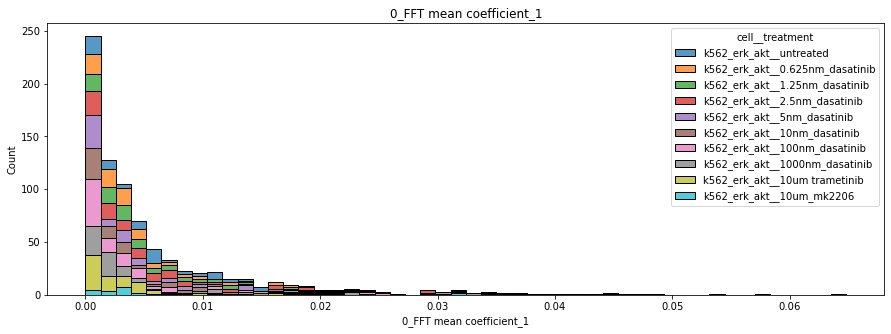

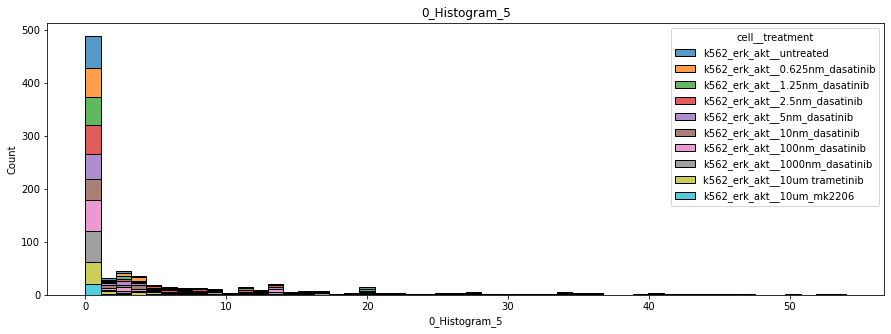

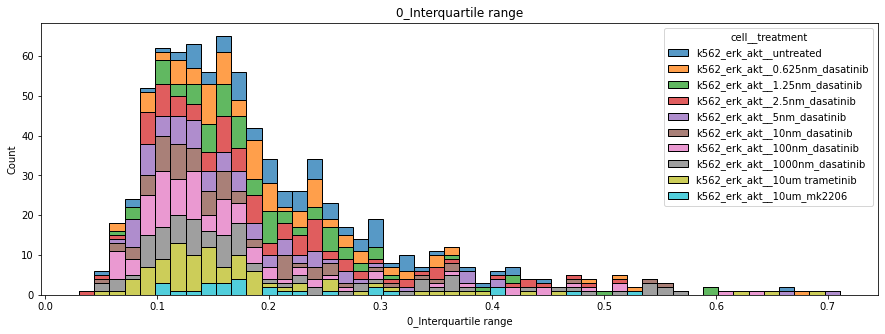

KeyboardInterrupt: 

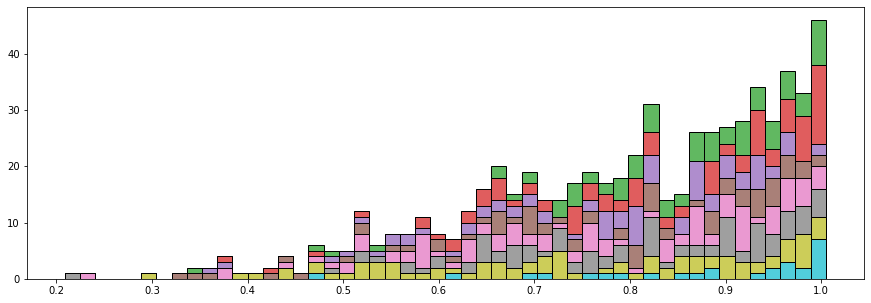

In [214]:
for feat in res2.columns[list(rfecv.get_support()) + [False, False]]: 
    plt.figure(figsize= (15,5))
    sbn.histplot(x=feat,kde=False, bins=50, hue='cell__treatment',multiple='stack', data=res)
    plt.title(feat)
    plt.show()

# umap 

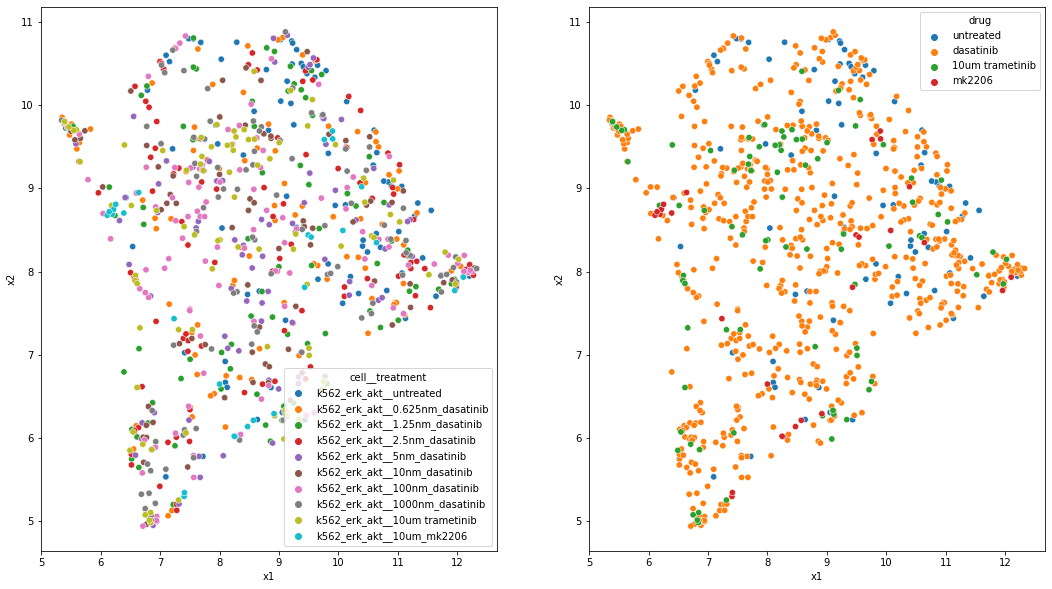

In [217]:
#scaled_res = StandardScaler().fit_transform(res[res.columns[:-2]].values)

reducer = umap.UMAP(n_neighbors=45, min_dist=0.01, n_components=2, metric='euclidean')

embedding = reducer.fit_transform(X3)# scaled_res)
embedding.shape

umap_res = pd.DataFrame(embedding).rename({0:'x1', 1:'x2'}, axis=1).assign(cell__treatment=res.cell__treatment,
                                                                          drug = [x.split('_')[-1] for x in res.cell__treatment])

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='x1', y='x2', hue='cell__treatment', data=umap_res, ax=axes[0], s=40)
sbn.scatterplot(x='x1', y='x2', hue='drug', data=umap_res, ax=axes[1], s=40)
plt.show()

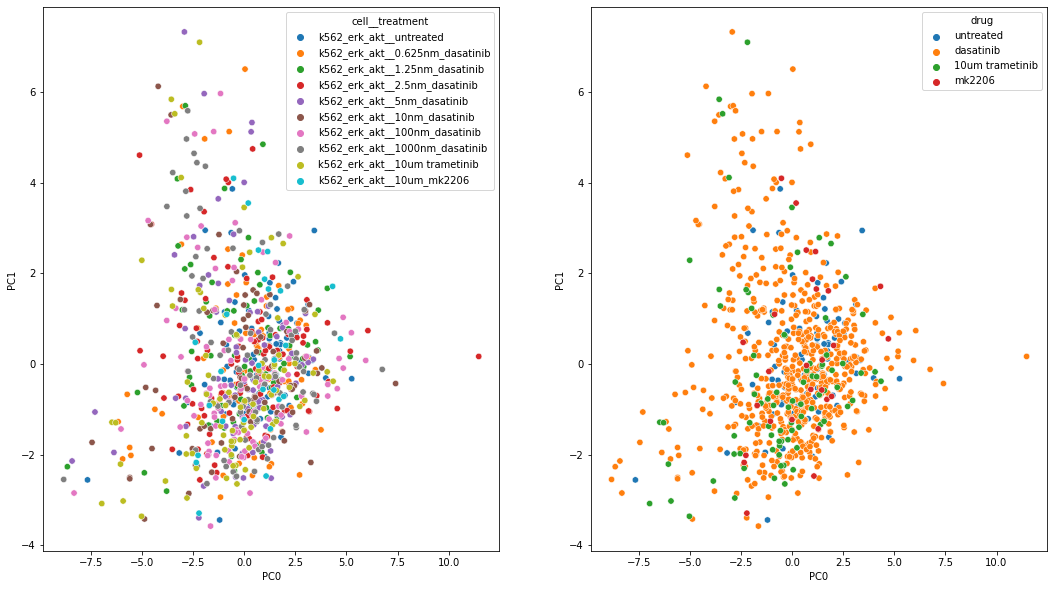

In [216]:
pca = decomposition.PCA(n_components=2)
pca.fit(X3)#scaled_res)
_X3 = pca.transform(X3)

pca_res = pd.DataFrame(_X3, columns=['PC0','PC1']).assign(cell__treatment=res.cell__treatment,
                                                         drug = [x.split('_')[-1] for x in res.cell__treatment])

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='cell__treatment', data=pca_res, ax=axes[0], s=40)
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=pca_res, ax=axes[1], s=40)
plt.show()

# Analysis 3: Pathway Correlation 

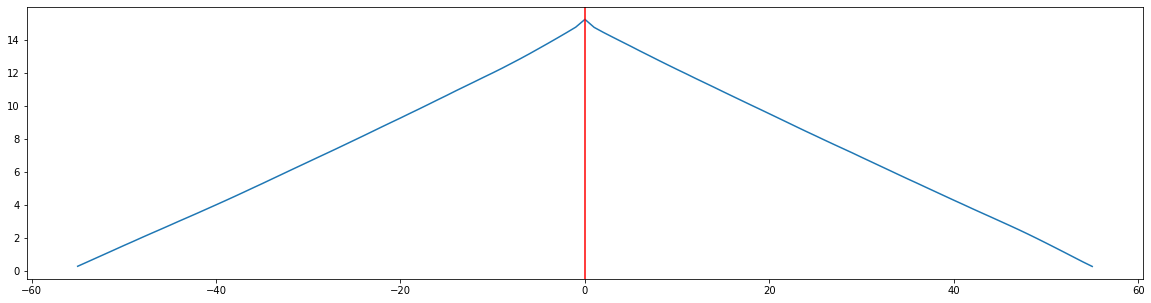

In [218]:
cc = [] 
for i, row in data.iterrows(): cc.append( np.correlate(row[data.attrs['clover_selector']].values, row[data.attrs['mscarlet_selector']].values, mode='full') )
cc = np.array(cc)
cc = cc.astype(np.float)

# Is there an overall increased cross correllation? 

shift = np.concatenate((np.arange(-len(data.attrs['clover_selector']) + 1,1,1),np.arange(1,len(data.attrs['clover_selector']),1)))
plt.figure(figsize=(20,5))
plt.plot(shift, cc.mean(axis=0))
plt.axvline(0, c='r')
plt.show()

In [219]:
res = pd.DataFrame(cc, columns=shift)
res = res.assign(cell__treatment=data.cell__treatment)
res.head()

-55       -54       -53       -52       -51       -50       -49  \
0  0.348570  0.637033  0.929958  1.160694  1.448537  1.775410  2.099322   
1  0.403369  0.669707  1.094571  1.422197  1.858235  2.165950  2.570689   
2  0.458613  1.015023  1.365495  1.683865  2.029972  2.436444  2.976745   
3  0.331330  0.911088  1.028237  1.636883  2.052014  2.640109  3.054450   
4  0.394581  0.750837  1.013412  1.337232  1.663247  2.009615  2.307640   

        -48       -47       -46  ...        47        48        49        50  \
0  2.471761  2.906421  3.314588  ...  4.125996  3.825116  3.554598  3.299214   
1  2.912718  3.231152  3.587238  ...  3.801547  3.373013  2.959664  2.554592   
2  3.504486  4.024599  4.570860  ...  5.015001  4.428047  3.843448  3.299991   
3  3.311292  4.151877  4.429921  ...  2.858513  2.469748  2.340751  2.097722   
4  2.727746  3.090722  3.457530  ...  5.632492  5.307980  4.710118  4.119298   

         51        52        53        54        55          cell__treatment  
0  2.917037  2.453059  1.953943  1.252477  0.647761  k562_erk_akt__untreated  
1  2.250201  1.874344  1.391295  0.917779  0.553712  k562_erk_akt__untreated  
2  2.768162  2.136335  1.567647  1.008142  0.476964  k562_erk_akt__untreated  
3  1.811290  1.475909  1.117264  0.945895  0.380690  k562_erk_akt__untreated  
4  3.459238  2.812049  2.178282  1.567756  0.737996  k562_erk_akt__untreated  

[5 rows x 112 columns]

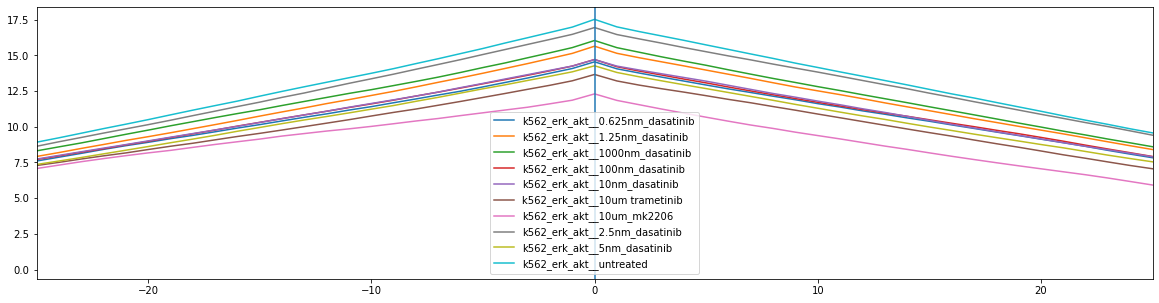

In [220]:
stats = res.groupby('cell__treatment').mean()#.reset_index()

plt.figure(figsize=(20,5))
for i,row in stats.iterrows(): 
    plt.plot(shift, row[shift], label=i)
plt.axvline(0)
plt.xlim(-25,25)
plt.legend()
plt.show()

# what is the max of each time series? 

In [221]:
#res = res.fillna(0)
res = res.assign(max_cc=[max(x) for x in res[shift].values])
res.head()

-55       -54       -53       -52       -51       -50       -49  \
0  0.348570  0.637033  0.929958  1.160694  1.448537  1.775410  2.099322   
1  0.403369  0.669707  1.094571  1.422197  1.858235  2.165950  2.570689   
2  0.458613  1.015023  1.365495  1.683865  2.029972  2.436444  2.976745   
3  0.331330  0.911088  1.028237  1.636883  2.052014  2.640109  3.054450   
4  0.394581  0.750837  1.013412  1.337232  1.663247  2.009615  2.307640   

        -48       -47       -46  ...        48        49        50        51  \
0  2.471761  2.906421  3.314588  ...  3.825116  3.554598  3.299214  2.917037   
1  2.912718  3.231152  3.587238  ...  3.373013  2.959664  2.554592  2.250201   
2  3.504486  4.024599  4.570860  ...  4.428047  3.843448  3.299991  2.768162   
3  3.311292  4.151877  4.429921  ...  2.469748  2.340751  2.097722  1.811290   
4  2.727746  3.090722  3.457530  ...  5.307980  4.710118  4.119298  3.459238   

         52        53        54        55          cell__treatment     max_cc  
0  2.453059  1.953943  1.252477  0.647761  k562_erk_akt__untreated  22.674105  
1  1.874344  1.391295  0.917779  0.553712  k562_erk_akt__untreated  24.482923  
2  2.136335  1.567647  1.008142  0.476964  k562_erk_akt__untreated  29.820789  
3  1.475909  1.117264  0.945895  0.380690  k562_erk_akt__untreated  24.088580  
4  2.812049  2.178282  1.567756  0.737996  k562_erk_akt__untreated  26.062786  

[5 rows x 113 columns]

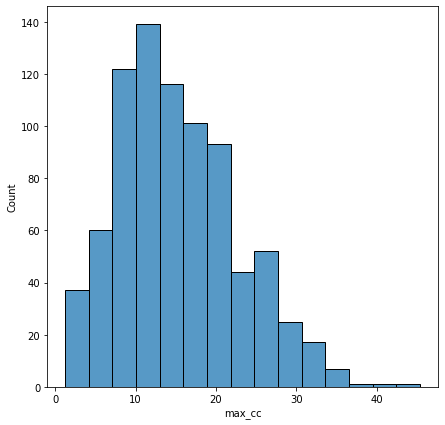

In [222]:
plt.figure(figsize=(7,7))
sbn.histplot(x='max_cc', data=res, bins=15)
plt.show()

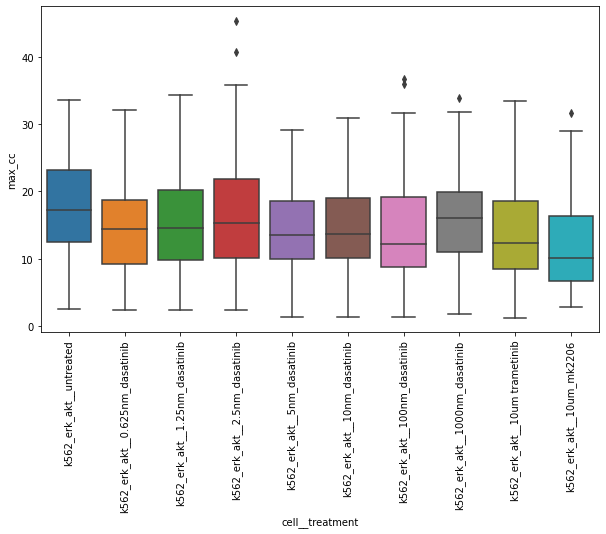

In [223]:
plt.figure(figsize=(10,6))
sbn.boxplot(y='max_cc', data=res, x='cell__treatment')
plt.xticks(rotation=90)
plt.show()

In [224]:
res.groupby('cell__treatment')['max_cc'].agg(['mean','std','count'])

mean       std  count
cell__treatment                                            
k562_erk_akt__0.625nm_dasatinib  14.543985  6.351644     91
k562_erk_akt__1.25nm_dasatinib   15.642732  7.667202     83
k562_erk_akt__1000nm_dasatinib   16.037162  6.535763     91
k562_erk_akt__100nm_dasatinib    14.706151  7.839874    103
k562_erk_akt__10nm_dasatinib     14.733232  7.205435     76
k562_erk_akt__10um trametinib    13.664926  7.481175     85
k562_erk_akt__10um_mk2206        12.309581  7.946238     27
k562_erk_akt__2.5nm_dasatinib    16.957682  8.811323     99
k562_erk_akt__5nm_dasatinib      14.267757  6.640667     81
k562_erk_akt__untreated          17.522139  7.061653     80

# Side bar: how does this change if we look at `no shift` correllation? 

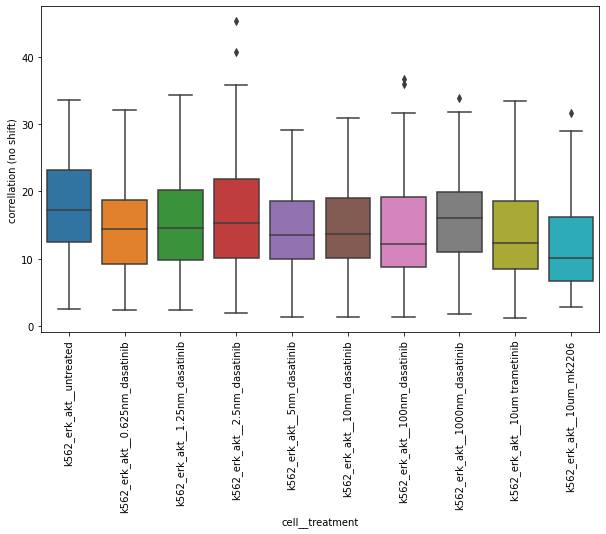

In [225]:
plt.figure(figsize=(10,6))
sbn.boxplot(y=0, data=res, x='cell__treatment')
plt.ylabel('correllation (no shift)')
plt.xticks(rotation=90)
plt.show()

# where does the maximum shift occur?

In [226]:
res = res.assign(max_idx=[shift[np.argmax(x)] for x in res[shift].values])
res.head()

-55       -54       -53       -52       -51       -50       -49  \
0  0.348570  0.637033  0.929958  1.160694  1.448537  1.775410  2.099322   
1  0.403369  0.669707  1.094571  1.422197  1.858235  2.165950  2.570689   
2  0.458613  1.015023  1.365495  1.683865  2.029972  2.436444  2.976745   
3  0.331330  0.911088  1.028237  1.636883  2.052014  2.640109  3.054450   
4  0.394581  0.750837  1.013412  1.337232  1.663247  2.009615  2.307640   

        -48       -47       -46  ...        49        50        51        52  \
0  2.471761  2.906421  3.314588  ...  3.554598  3.299214  2.917037  2.453059   
1  2.912718  3.231152  3.587238  ...  2.959664  2.554592  2.250201  1.874344   
2  3.504486  4.024599  4.570860  ...  3.843448  3.299991  2.768162  2.136335   
3  3.311292  4.151877  4.429921  ...  2.340751  2.097722  1.811290  1.475909   
4  2.727746  3.090722  3.457530  ...  4.710118  4.119298  3.459238  2.812049   

         53        54        55          cell__treatment     max_cc  max_idx  
0  1.953943  1.252477  0.647761  k562_erk_akt__untreated  22.674105        0  
1  1.391295  0.917779  0.553712  k562_erk_akt__untreated  24.482923        0  
2  1.567647  1.008142  0.476964  k562_erk_akt__untreated  29.820789        0  
3  1.117264  0.945895  0.380690  k562_erk_akt__untreated  24.088580        0  
4  2.178282  1.567756  0.737996  k562_erk_akt__untreated  26.062786        0  

[5 rows x 114 columns]

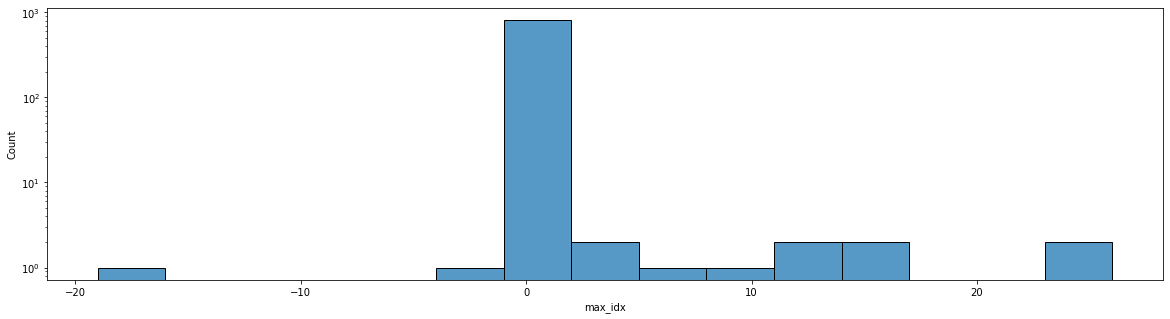

In [227]:
f, ax = plt.subplots(1,1,figsize=(20,5))
sbn.histplot(x='max_idx', data=res, bins=15)
ax.set_yscale('log')
plt.show()

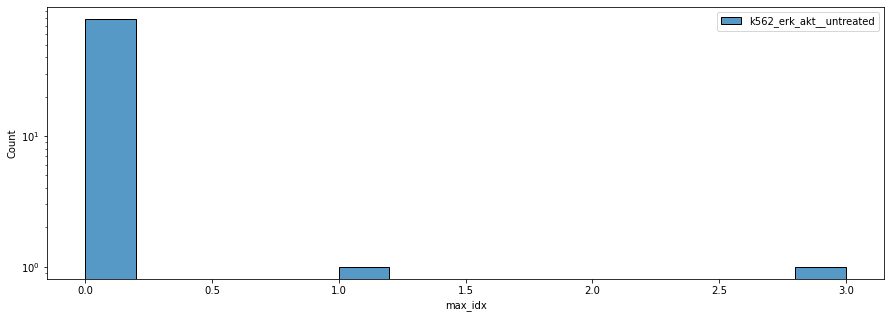

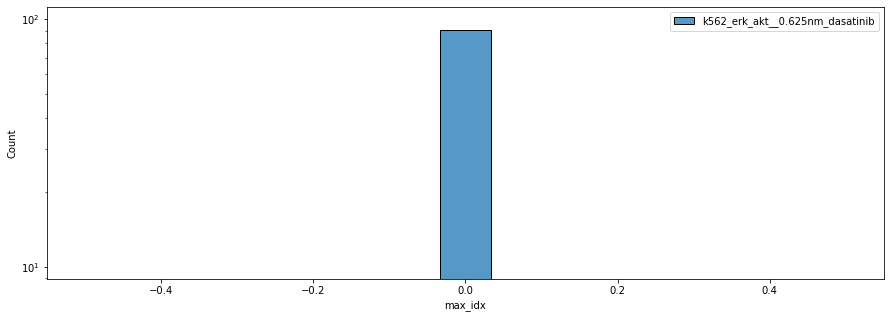

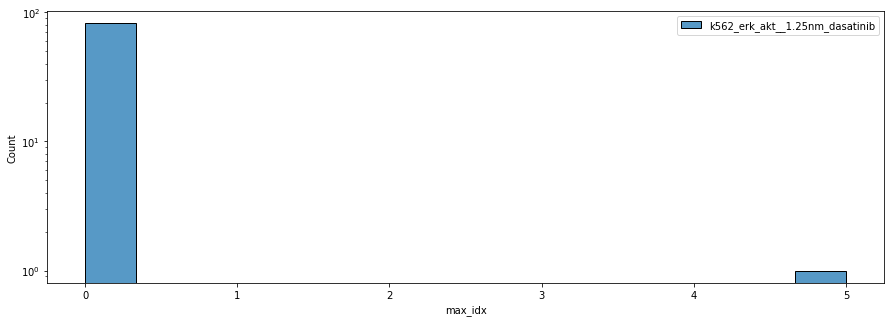

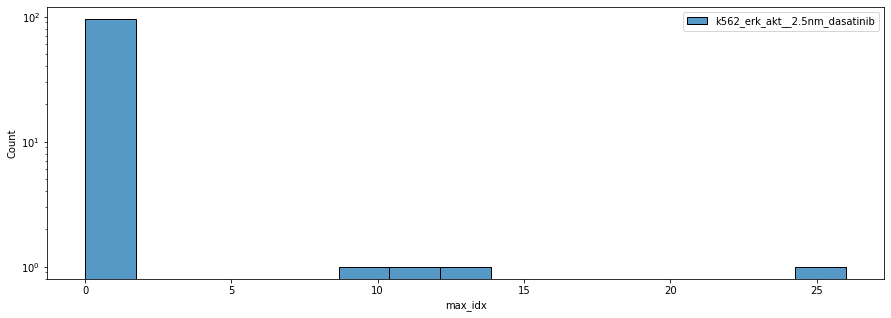

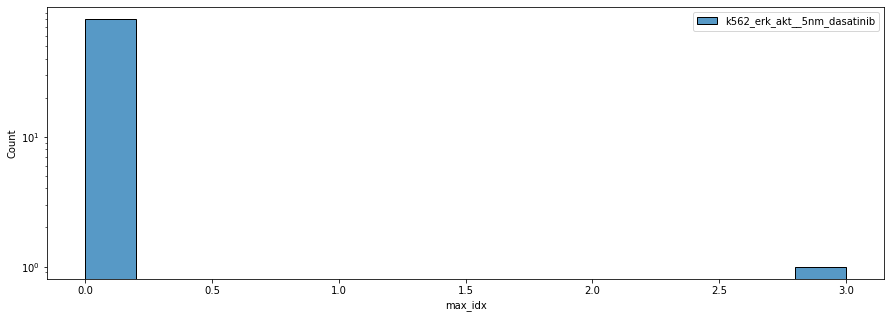

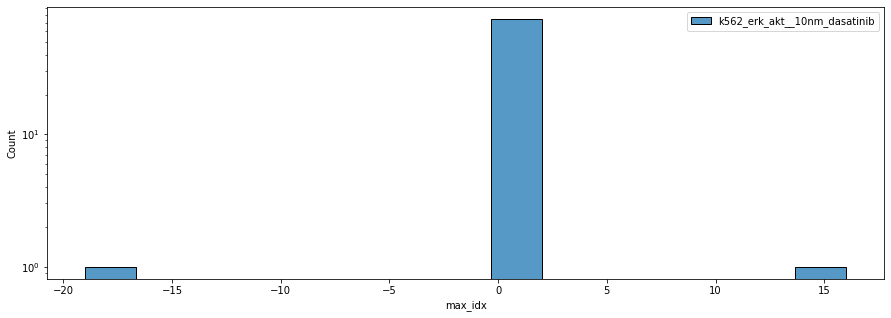

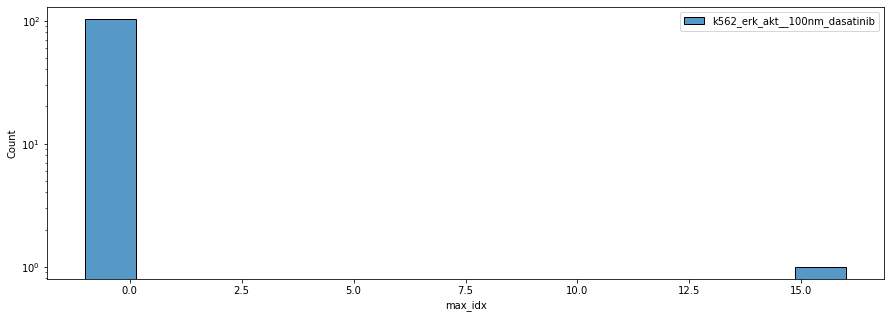

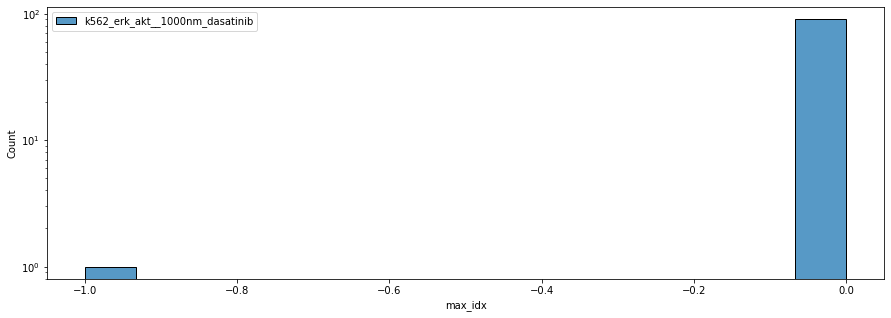

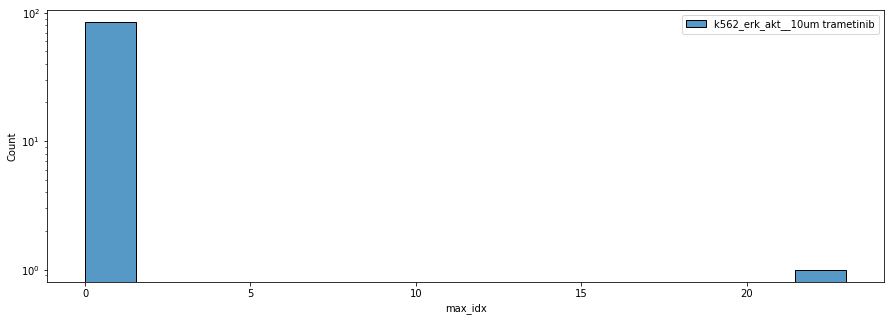

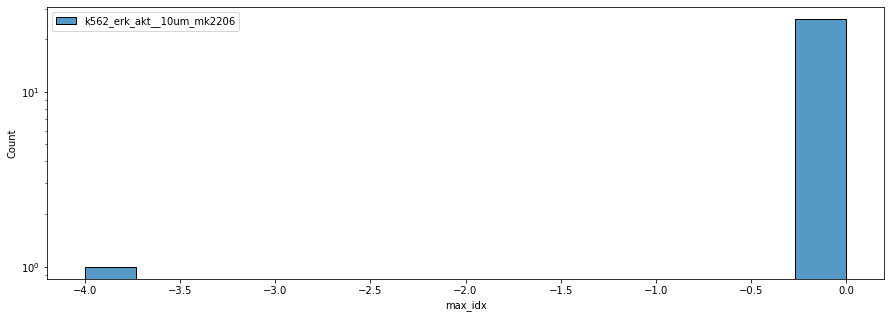

In [228]:
for ct in res.cell__treatment.unique(): 
    temp = res[res.cell__treatment == ct]
    f, ax = plt.subplots(1,1,figsize=(15,5))
    sbn.histplot(x='max_idx', data=temp, bins=15, label=ct)
    ax.set_yscale('log')
    plt.legend()
    plt.show()

# what about `max_cc` vs `max_idx`

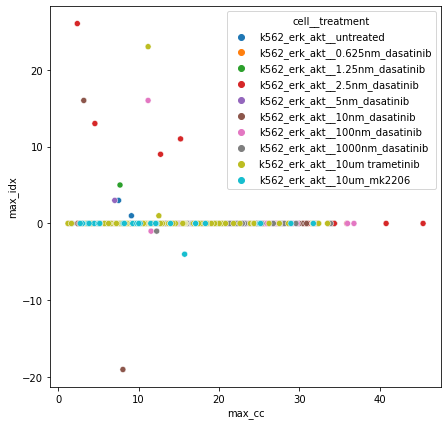

In [229]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='max_cc', y='max_idx', data=res, hue='cell__treatment')
plt.show()

# can we compare time series by the lag-lead order? e.g., does pathway A lag or lead - binarize via `max_idx` ? 

In [230]:
res = res.assign(pos_idx=lambda x: x.max_idx > 0, neg_idx=lambda x: x.max_idx < 0)

In [231]:
temp = res.groupby('cell__treatment').mean().reset_index()
temp.head()

cell__treatment       -55       -54       -53       -52  \
0  k562_erk_akt__0.625nm_dasatinib  0.238345  0.473409  0.717815  0.954099   
1   k562_erk_akt__1.25nm_dasatinib  0.254091  0.498273  0.742164  0.996596   
2   k562_erk_akt__1000nm_dasatinib  0.270737  0.538664  0.816976  1.094009   
3    k562_erk_akt__100nm_dasatinib  0.267342  0.527599  0.781196  1.031288   
4     k562_erk_akt__10nm_dasatinib  0.252112  0.495734  0.737182  0.974655   

        -51       -50       -49       -48       -47  ...        50        51  \
0  1.174328  1.406953  1.640977  1.872354  2.101023  ...  1.585934  1.326549   
1  1.244151  1.490354  1.725110  1.966463  2.211922  ...  1.715167  1.421549   
2  1.373720  1.648468  1.908475  2.172207  2.439094  ...  1.812491  1.511580   
3  1.281906  1.537623  1.778584  2.026200  2.277266  ...  1.709784  1.424995   
4  1.221181  1.465773  1.719838  1.972495  2.207763  ...  1.563896  1.296229   

         52        53        54        55     max_cc   max_idx   pos_idx  \
0  1.068205  0.781200  0.495619  0.235323  14.543985  0.000000  0.000000   
1  1.127056  0.829033  0.533300  0.259788  15.642732  0.060241  0.012048   
2  1.198436  0.882192  0.566787  0.260896  16.037162 -0.010989  0.000000   
3  1.143854  0.851990  0.557135  0.264288  14.706151  0.145631  0.009709   
4  1.019361  0.748519  0.487331  0.232088  14.733232 -0.039474  0.013158   

    neg_idx  
0  0.000000  
1  0.000000  
2  0.010989  
3  0.009709  
4  0.013158  

[5 rows x 116 columns]

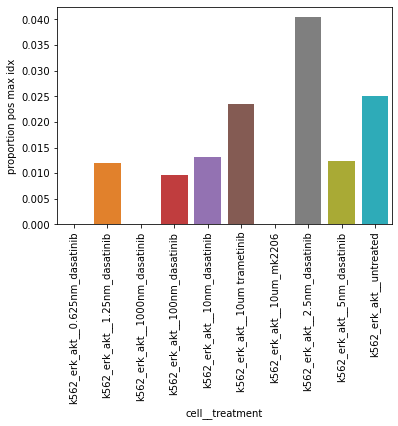

In [232]:
# proportion of positive max_idx
plt.figure()
sbn.barplot(x='cell__treatment', y='pos_idx', data=temp)
plt.ylabel('proportion pos max idx')
plt.xticks(rotation=90)
plt.show()

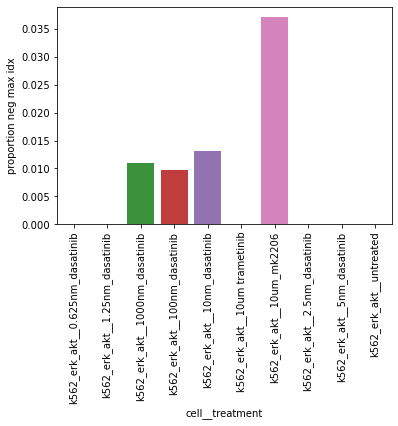

In [233]:
# proportion of positive max_idx
plt.figure()
sbn.barplot(x='cell__treatment', y='neg_idx', data=temp)
plt.ylabel('proportion neg max idx')
plt.xticks(rotation=90)
plt.show()